In [1]:
import sys
from pathlib import Path
import os
cwd = os.getcwd()
parent = str(Path(cwd).parents[0])
sys.path.append(parent)

In [2]:
import schemdraw
from schemdraw import flow

import pandas as pd
import numpy as np

from lifelines import KaplanMeierFitter
#from lifelines_fix import add_at_risk_counts
from lifelines.plotting import add_at_risk_counts
from lifelines import AalenJohansenFitter
import warnings

import matplotlib.pyplot as plt 
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
%matplotlib inline

In [3]:
from matplotlib.pyplot import Text

# Loading Data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/maia-sh/direcct2/master/data/analysis/kaplan-meier-time-to-pub.csv?token=GHSAT0AAAAAABXKCQD4HXSPYAEQ5KKN7UV6YX6DLWA')
df.head()

,id,date_completion,publication_preprint,publication_article,publication_summary,publication_any,date_publication_preprint,date_publication_article,date_publication_summary,date_publication_any,time_publication_preprint,time_publication_article,time_publication_summary,time_publication_any
0,tri00002,2020-04-30,True,True,False,True,2020-03-23,2020-05-19,NaN,2020-03-23,-38.0,19.0,NaN,-38.0
1,tri00022,2020-04-16,False,True,False,True,NaN,2020-08-13,NaN,2020-08-13,NaN,119.0,NaN,119.0
2,tri00043,2020-06-30,False,True,False,True,NaN,2020-05-28,NaN,2020-05-28,NaN,-33.0,NaN,-33.0
3,tri00047,2020-05-10,True,True,False,True,2020-08-29,2021-03-09,NaN,2020-08-29,111.0,303.0,NaN,111.0
4,tri00049,2020-05-31,True,True,False,True,2021-02-03,2021-09-16,NaN,2021-02-03,248.0,473.0,NaN,248.0


In [5]:
#Making a copy to mess around with
df2 = df.copy()

In [6]:
results_cutoff = pd.to_datetime('2021-08-15')

To Do: 
1. Remove dates after August 15th 2021 (or other date this gets changes to) XX
2. Fix what this does to other columns XX
2. Zero out negative follow-ups XX (doing this per graph)
3. Create columns accounting for censorship XX
4. Make date into dates XX
5. Prepare for A-J XX
6. Write sanity checks

# Making Dates into Dates

In [7]:
for x in df2.columns:
    if 'date' in x:
        df2[x] = pd.to_datetime(df2[x])

# Joining in IDs

In [9]:
df_reg = pd.read_csv('https://raw.githubusercontent.com/maia-sh/direcct2/master/data/analysis/trials.csv?token=GHSAT0AAAAAABXKCQD5FQPXTQDNYMSYQFLKYX6DNIA')

In [10]:
df2 = df2.merge(df_reg[['id', 'trn']], on='id', how='left')

# Filtering out post cut-off dates

In [11]:
df2['date_publication_preprint_adj'] = np.where(df2.date_publication_preprint > results_cutoff, pd.NaT, df2.date_publication_preprint)
df2['date_publication_preprint_adj'] = pd.to_datetime(df2['date_publication_preprint_adj'])

In [12]:
df2['date_publication_article_adj'] = np.where(df2.date_publication_article > results_cutoff, pd.NaT, df2.date_publication_article)
df2['date_publication_article_adj'] = pd.to_datetime(df2['date_publication_article_adj'])

In [13]:
df2['date_publication_summary_adj'] = np.where(df2.date_publication_summary > results_cutoff, pd.NaT, df2.date_publication_summary)
df2['date_publication_summary_adj'] = pd.to_datetime(df2['date_publication_summary_adj'])

# Then we need to re-create the other columns from that adjusted data

In [14]:
#Reporting variables
df2['publication_preprint_adj'] = np.where(df2['date_publication_preprint_adj'].notnull(), True, False)
df2['publication_article_adj'] = np.where(df2['date_publication_article_adj'].notnull(), True, False)
df2['publication_summary_adj'] = np.where(df2['date_publication_summary_adj'].notnull(), True, False)
df2['publication_any_adj'] = np.where(df2['publication_preprint_adj'] | df2['publication_article_adj'] | df2['publication_summary_adj'], True, False)

In [15]:
#Time to reporting by route
df2['time_publication_preprint_adj'] = np.where(df2.publication_preprint_adj, 
                                                (df2.date_publication_preprint_adj - df2.date_completion) / pd.Timedelta('1 day'),
                                                (results_cutoff - df2.date_completion) / pd.Timedelta('1 day'))

df2['time_publication_article_adj'] = np.where(df2.publication_article_adj, 
                                                (df2.date_publication_article_adj - df2.date_completion) / pd.Timedelta('1 day'),
                                                (results_cutoff - df2.date_completion) / pd.Timedelta('1 day'))

df2['time_publication_summary_adj'] = np.where(df2.publication_summary_adj, 
                                                (df2.date_publication_summary_adj - df2.date_completion) / pd.Timedelta('1 day'),
                                                (results_cutoff - df2.date_completion) / pd.Timedelta('1 day'))

In [16]:
#Time to reporting any

df2['time_reporting_any_adj'] = df2[['time_publication_preprint_adj', 'time_publication_article_adj', 'time_publication_summary_adj']].min(axis=1)

# Overall Reporting Rate

In [17]:
df2.columns

Index(['id', 'date_completion', 'publication_preprint', 'publication_article',
       'publication_summary', 'publication_any', 'date_publication_preprint',
       'date_publication_article', 'date_publication_summary',
       'date_publication_any', 'time_publication_preprint',
       'time_publication_article', 'time_publication_summary',
       'time_publication_any', 'trn', 'date_publication_preprint_adj',
       'date_publication_article_adj', 'date_publication_summary_adj',
       'publication_preprint_adj', 'publication_article_adj',
       'publication_summary_adj', 'publication_any_adj',
       'time_publication_preprint_adj', 'time_publication_article_adj',
       'time_publication_summary_adj', 'time_reporting_any_adj'],
      dtype='object')

In [18]:
overall_cols = ['id', 'trn', 'date_completion', 'date_publication_preprint_adj', 'date_publication_article_adj', 
                'date_publication_summary_adj', 'publication_preprint_adj', 'publication_article_adj', 
                'publication_summary_adj', 'publication_any_adj', 'time_publication_preprint_adj', 
                'time_publication_article_adj','time_publication_summary_adj', 'time_reporting_any_adj']

In [19]:
adjusted_data = df2[overall_cols].reset_index(drop=True)

In [20]:
395/(395+1191)

0.24905422446406053

In [21]:
adjusted_data['preprint_to_jounral'] = (adjusted_data.date_publication_article_adj - adjusted_data.date_publication_preprint_adj) / pd.Timedelta('1 day')

In [22]:
adjusted_data[(adjusted_data.preprint_to_jounral <= 0)]

,id,trn,date_completion,date_publication_preprint_adj,date_publication_article_adj,date_publication_summary_adj,publication_preprint_adj,publication_article_adj,publication_summary_adj,publication_any_adj,time_publication_preprint_adj,time_publication_article_adj,time_publication_summary_adj,time_reporting_any_adj,preprint_to_jounral
78,tri01097,NCT04331808,2021-03-31,2021-05-24,2020-10-20,NaT,True,True,False,True,54.0,-162.0,137.0,-162.0,-216.0
92,tri01280,NCT04329923,2020-11-11,2021-02-26,2020-09-30,2020-12-10,True,True,True,True,107.0,-42.0,29.0,-42.0,-149.0
237,tri03276,NCT04304053,2020-06-15,2020-07-16,2020-07-16,NaT,True,True,False,True,31.0,31.0,426.0,31.0,0.0


In [23]:
adjusted_data[(adjusted_data.publication_preprint_adj == True) & 
              (adjusted_data.publication_article_adj == True) & 
              (adjusted_data.preprint_to_jounral >= 0)]['preprint_to_jounral'].describe()

count      87.000000
mean      212.287356
std       793.826733
min         0.000000
25%        62.000000
50%       110.000000
75%       176.500000
max      7480.000000
Name: preprint_to_jounral, dtype: float64

# Data Handling for A-J curves for time to preprint with article pub as a competing risk

In [24]:
competing_risks = df2[['id', 
                      'date_completion', 
                      'date_publication_article_adj', 
                      'date_publication_preprint_adj', 
                      'time_publication_article_adj', 
                      'time_publication_preprint_adj']].reset_index(drop=True)

In [25]:
cr_conds = [
    competing_risks.time_publication_preprint_adj <= competing_risks.time_publication_article_adj,
    (competing_risks.date_publication_article_adj.notnull() & competing_risks.date_publication_preprint_adj.isna())]

cr_out = [competing_risks.time_publication_preprint_adj, competing_risks.time_publication_article_adj]

competing_risks['time_cr'] = np.select(cr_conds, cr_out)

cr_event_conds = [
    competing_risks.date_publication_preprint_adj.notnull(),
    competing_risks.date_publication_preprint_adj.isna() & competing_risks.date_publication_article_adj.notnull(),
    competing_risks.date_publication_preprint_adj.isna() & competing_risks.date_publication_article_adj.isna()]

cr_event_out = [1, 2, 0]

competing_risks['event_cr'] = np.select(cr_event_conds, cr_event_out)
competing_risks['time_cr'] = np.where(competing_risks['time_cr'] < 0, 0, competing_risks['time_cr'])

In [26]:
d = competing_risks[['time_cr', 'event_cr']].reset_index(drop=True)
d = d.set_index('time_cr')

In [27]:
aj = AalenJohansenFitter(seed=10)

#This just hides the warning that data is randomly "jiggered" to break ties, which is fine.
#The seed for this is set above
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    aj.fit(competing_risks.time_cr, competing_risks.event_cr, event_of_interest=1)

In [28]:
aj_corrected = aj.cumulative_density_.reset_index()
aj_corrected = aj_corrected.set_index(aj_corrected.event_at.apply(round)).drop('event_at', axis=1)

In [29]:
d = aj_corrected.merge(d, how='outer', left_index=True, right_index=True)
d = d.loc[d['event_cr'] == 0].copy()

# Any Publication

In [31]:
any_pub = df2[['publication_any_adj', 'time_reporting_any_adj']].reset_index(drop=True)
any_pub['publication_any_adj'] = any_pub['publication_any_adj'].astype(int)
any_pub['time_reporting_any_adj'] = np.where(any_pub['time_reporting_any_adj'] < 0, 0, any_pub['time_reporting_any_adj'])

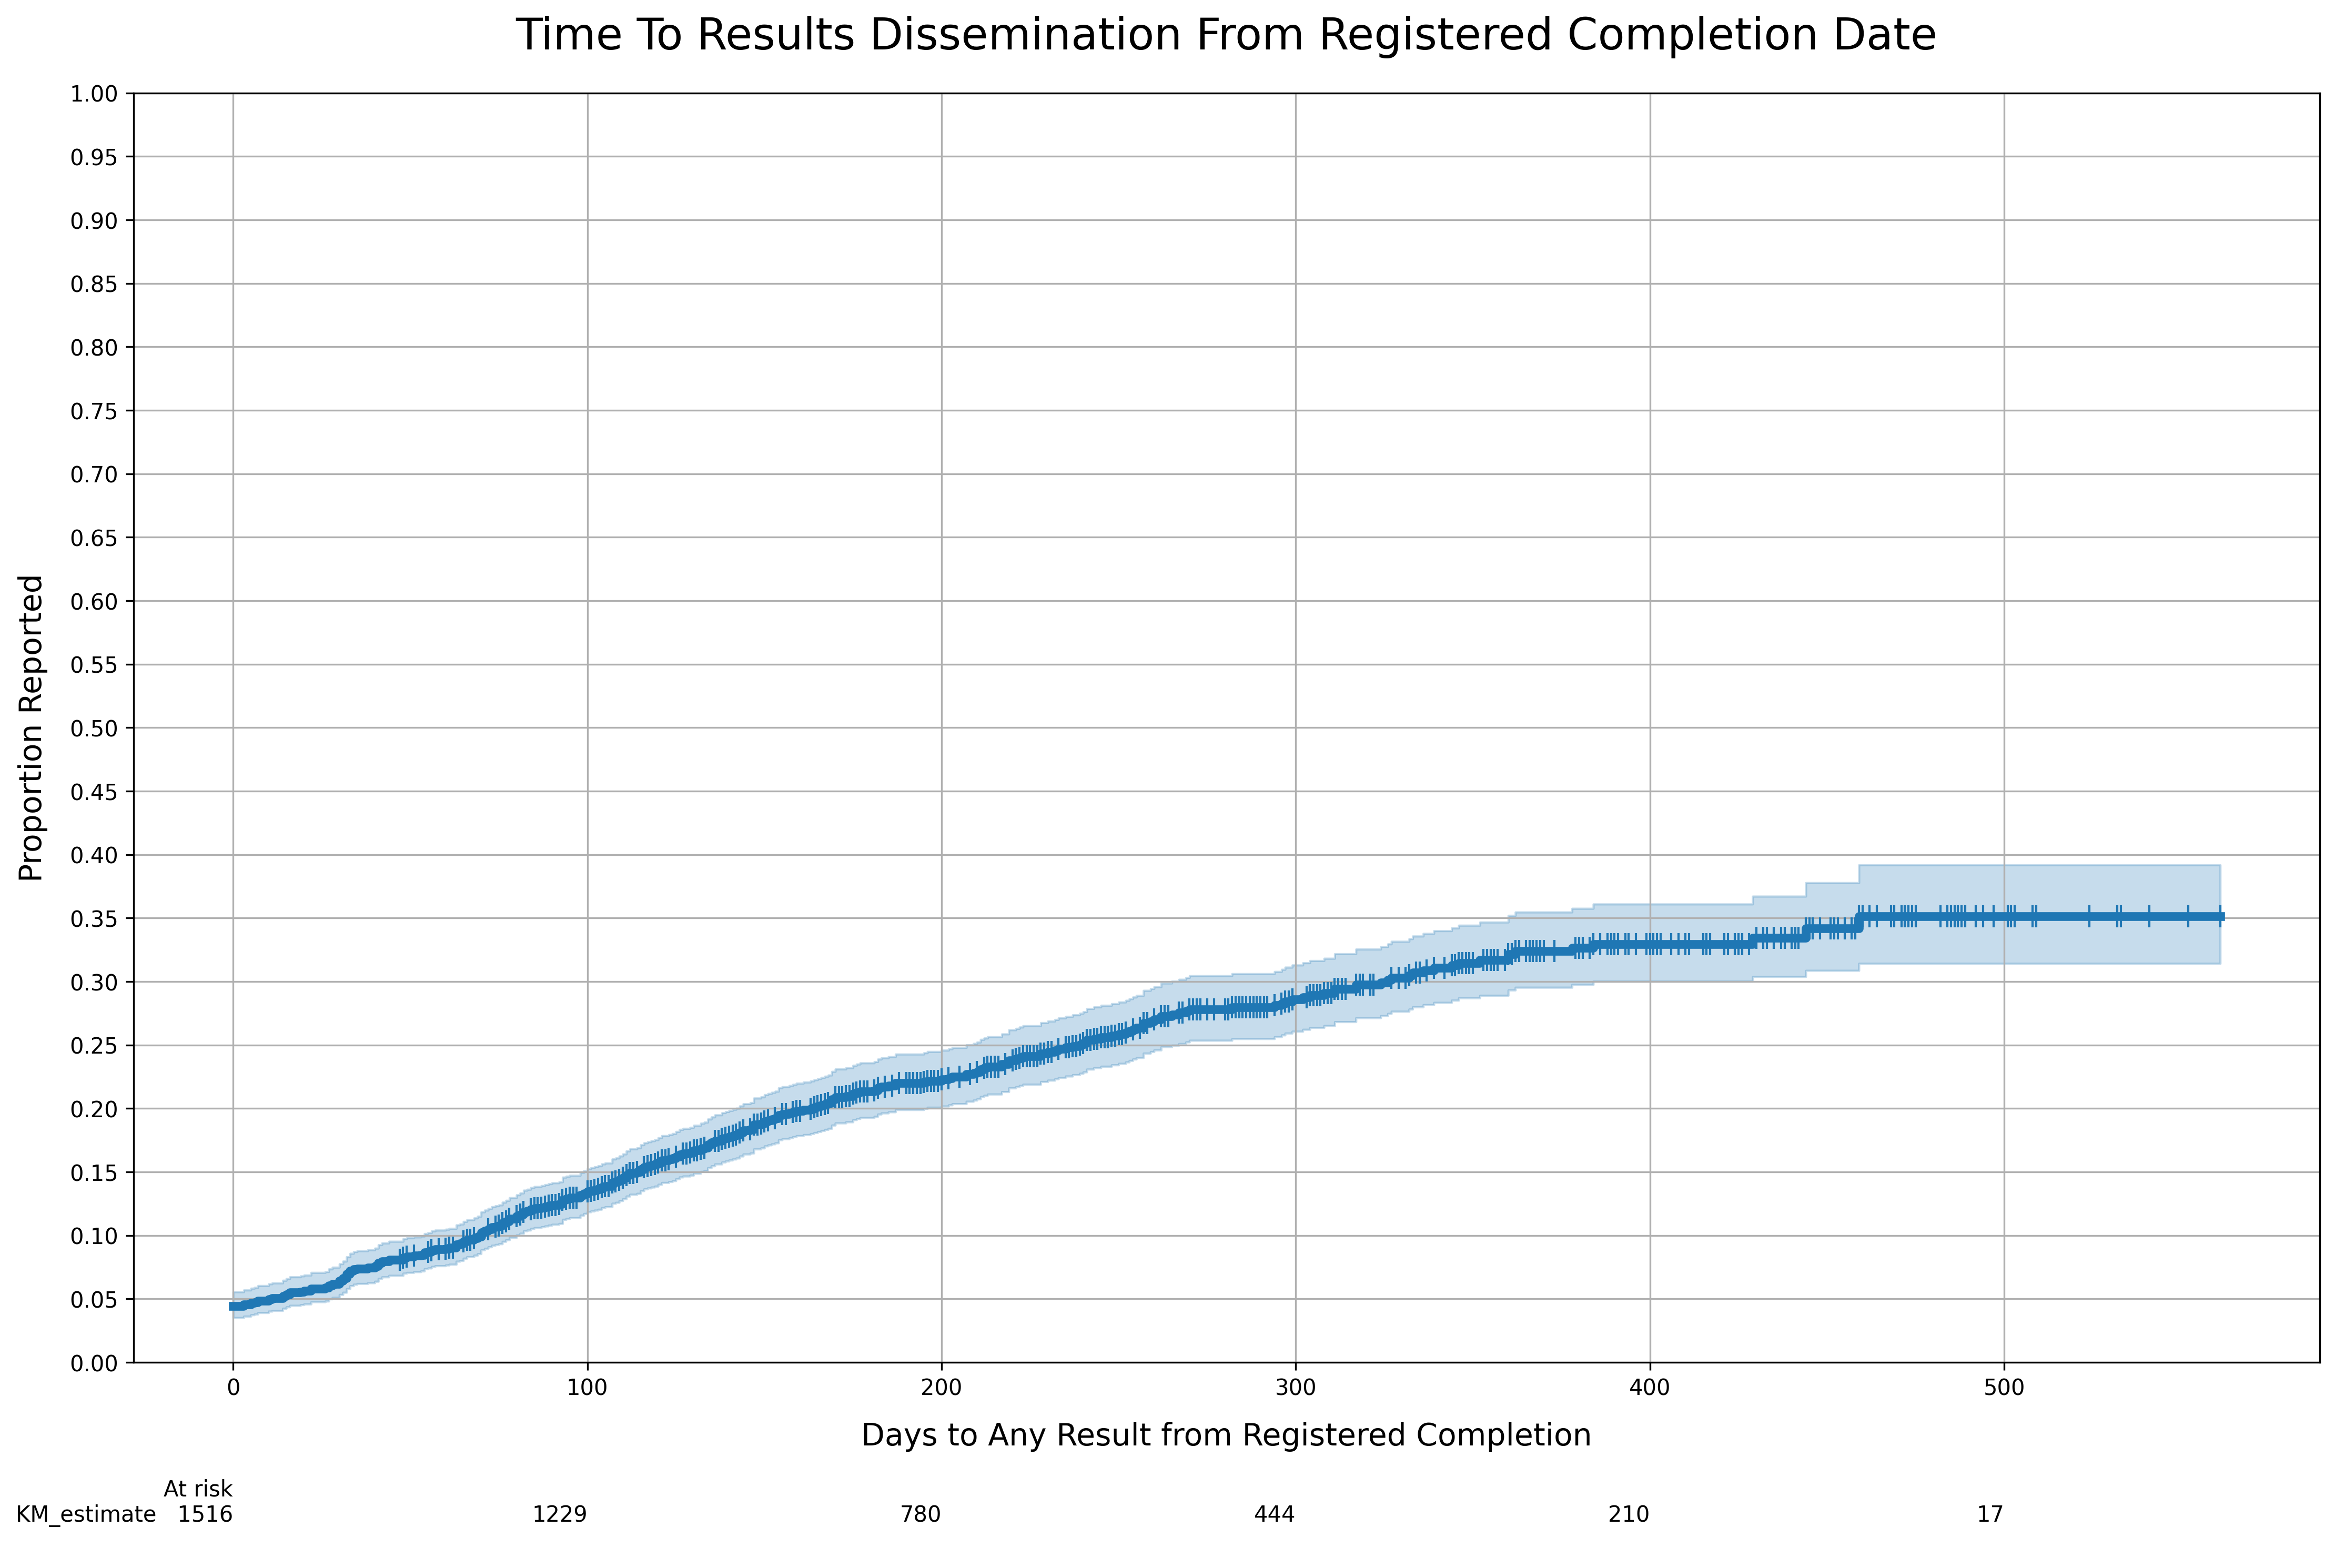

In [38]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(figsize = (10,10), dpi=300)
ax = plt.subplot()

T = any_pub.time_reporting_any_adj
E = any_pub.publication_any_adj

kmf_any = KaplanMeierFitter()
kmf_any.fit(T, E)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_any.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=4)

ax.set_ylim([0, 1])

plt.title("Time To Results Dissemination From Registered Completion Date", pad=20, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Result from Registered Completion', labelpad=10, fontsize=14)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_any, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

# Article Publication

In [39]:
article_pub = df2[['publication_article_adj', 'time_publication_article_adj']].reset_index(drop=True)
article_pub['publication_article_adj'] = article_pub['publication_article_adj'].astype(int)
article_pub['time_publication_article_adj'] = np.where(article_pub['time_publication_article_adj'] < 0, 0, article_pub['time_publication_article_adj'])

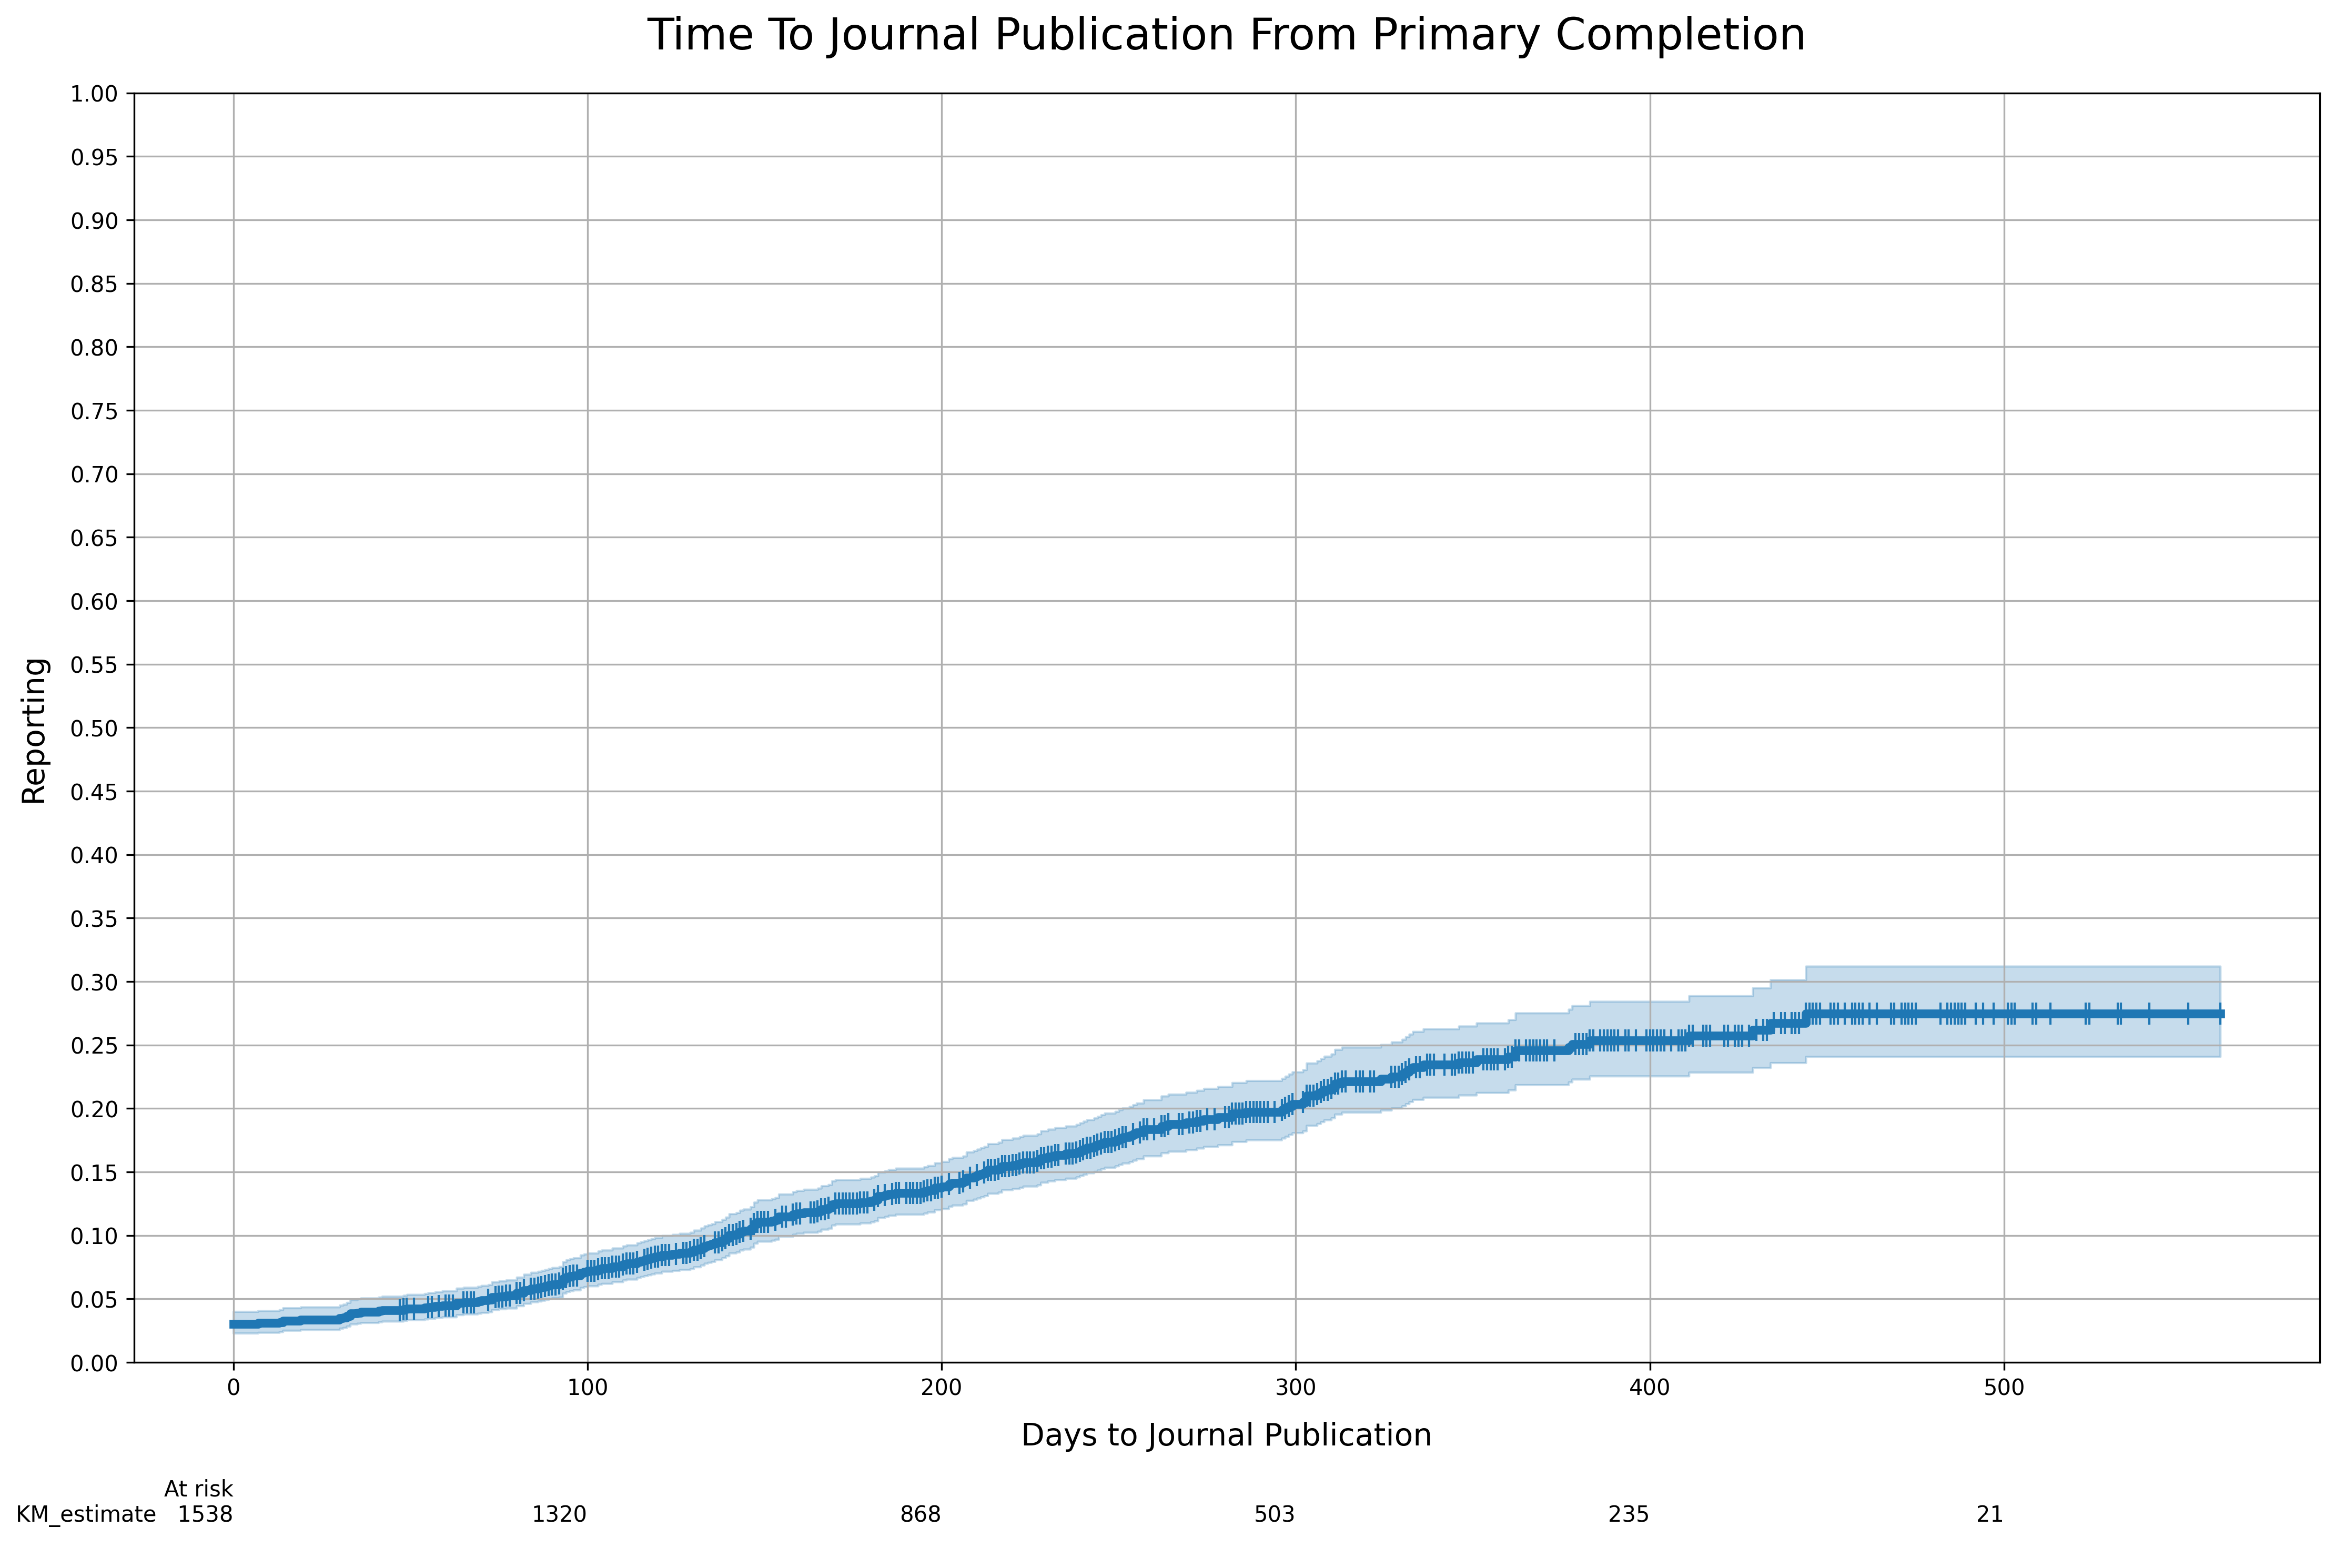

In [105]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T = article_pub.time_publication_article_adj
E = article_pub.publication_article_adj

kmf_article = KaplanMeierFitter()
kmf_article.fit(T, E)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_article.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=4)

ax.set_ylim([0, 1])

plt.title("Time To Journal Publication From Primary Completion", pad=20, fontsize=20)
plt.ylabel('Reporting', labelpad=10, fontsize=14)
plt.xlabel('Days to Journal Publication', labelpad=10, fontsize=14)

add_at_risk_counts(kmf_article, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

# Time to Preprint Publication (with article pub as competing risk)

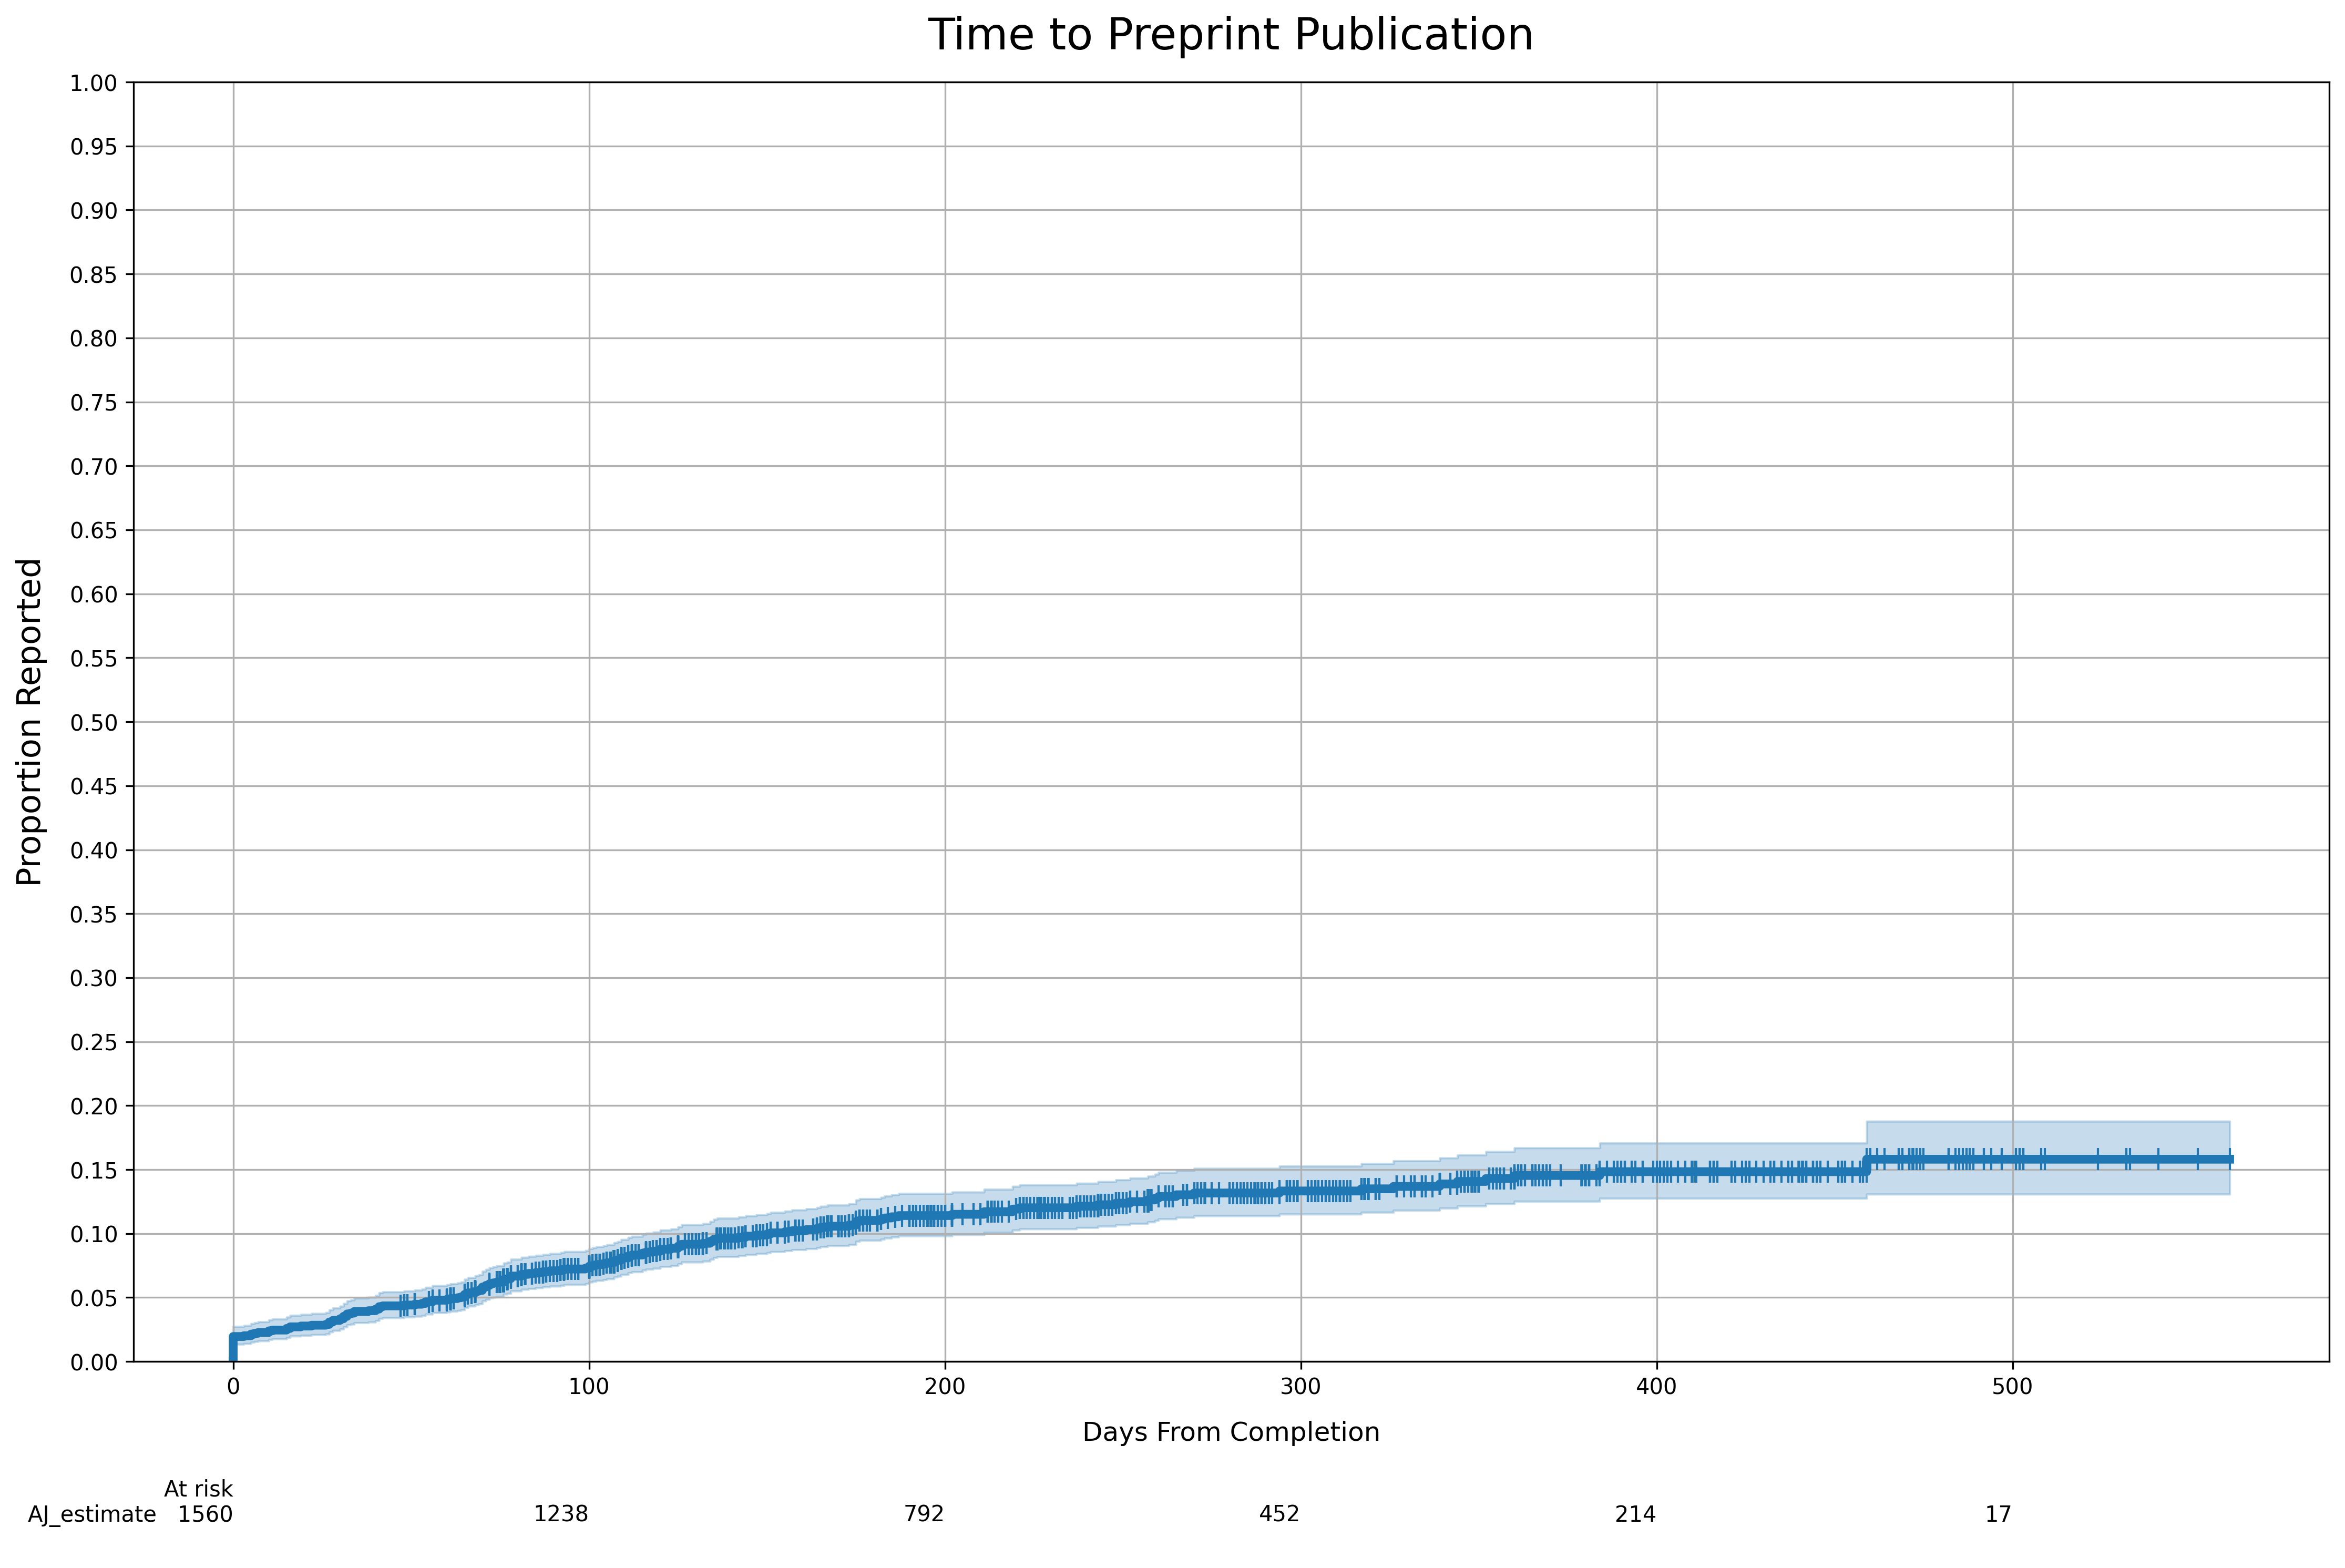

In [106]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

aj = AalenJohansenFitter(seed=10)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    aj.fit(competing_risks.time_cr, competing_risks.event_cr, event_of_interest=1)
aj.plot(yticks=yticks, figsize=(15,10), lw=4, legend=None, grid=True)
plt.plot(d.index, d['CIF_1'], '|', markersize=10, color='C0')

plt.title('Time to Preprint Publication', pad=15, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=15)
plt.xlabel('Days From Completion', labelpad=10, fontsize=12)

ax.set_ylim([0, 1])

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(aj, rows_to_show = ['At risk'])
plt.tight_layout()
plt.show()

# Registry results
-We may want to restrict this only to registrations on registries that can accept registry results?

In [42]:
reg_pub = df2[['publication_summary_adj', 'time_publication_summary_adj']].reset_index(drop=True)
reg_pub['publication_summary_adj'] = reg_pub['publication_summary_adj'].astype(int)
reg_pub['time_publication_summary_adj'] = np.where(reg_pub['time_publication_summary_adj'] < 0, 0, reg_pub['time_publication_summary_adj'])

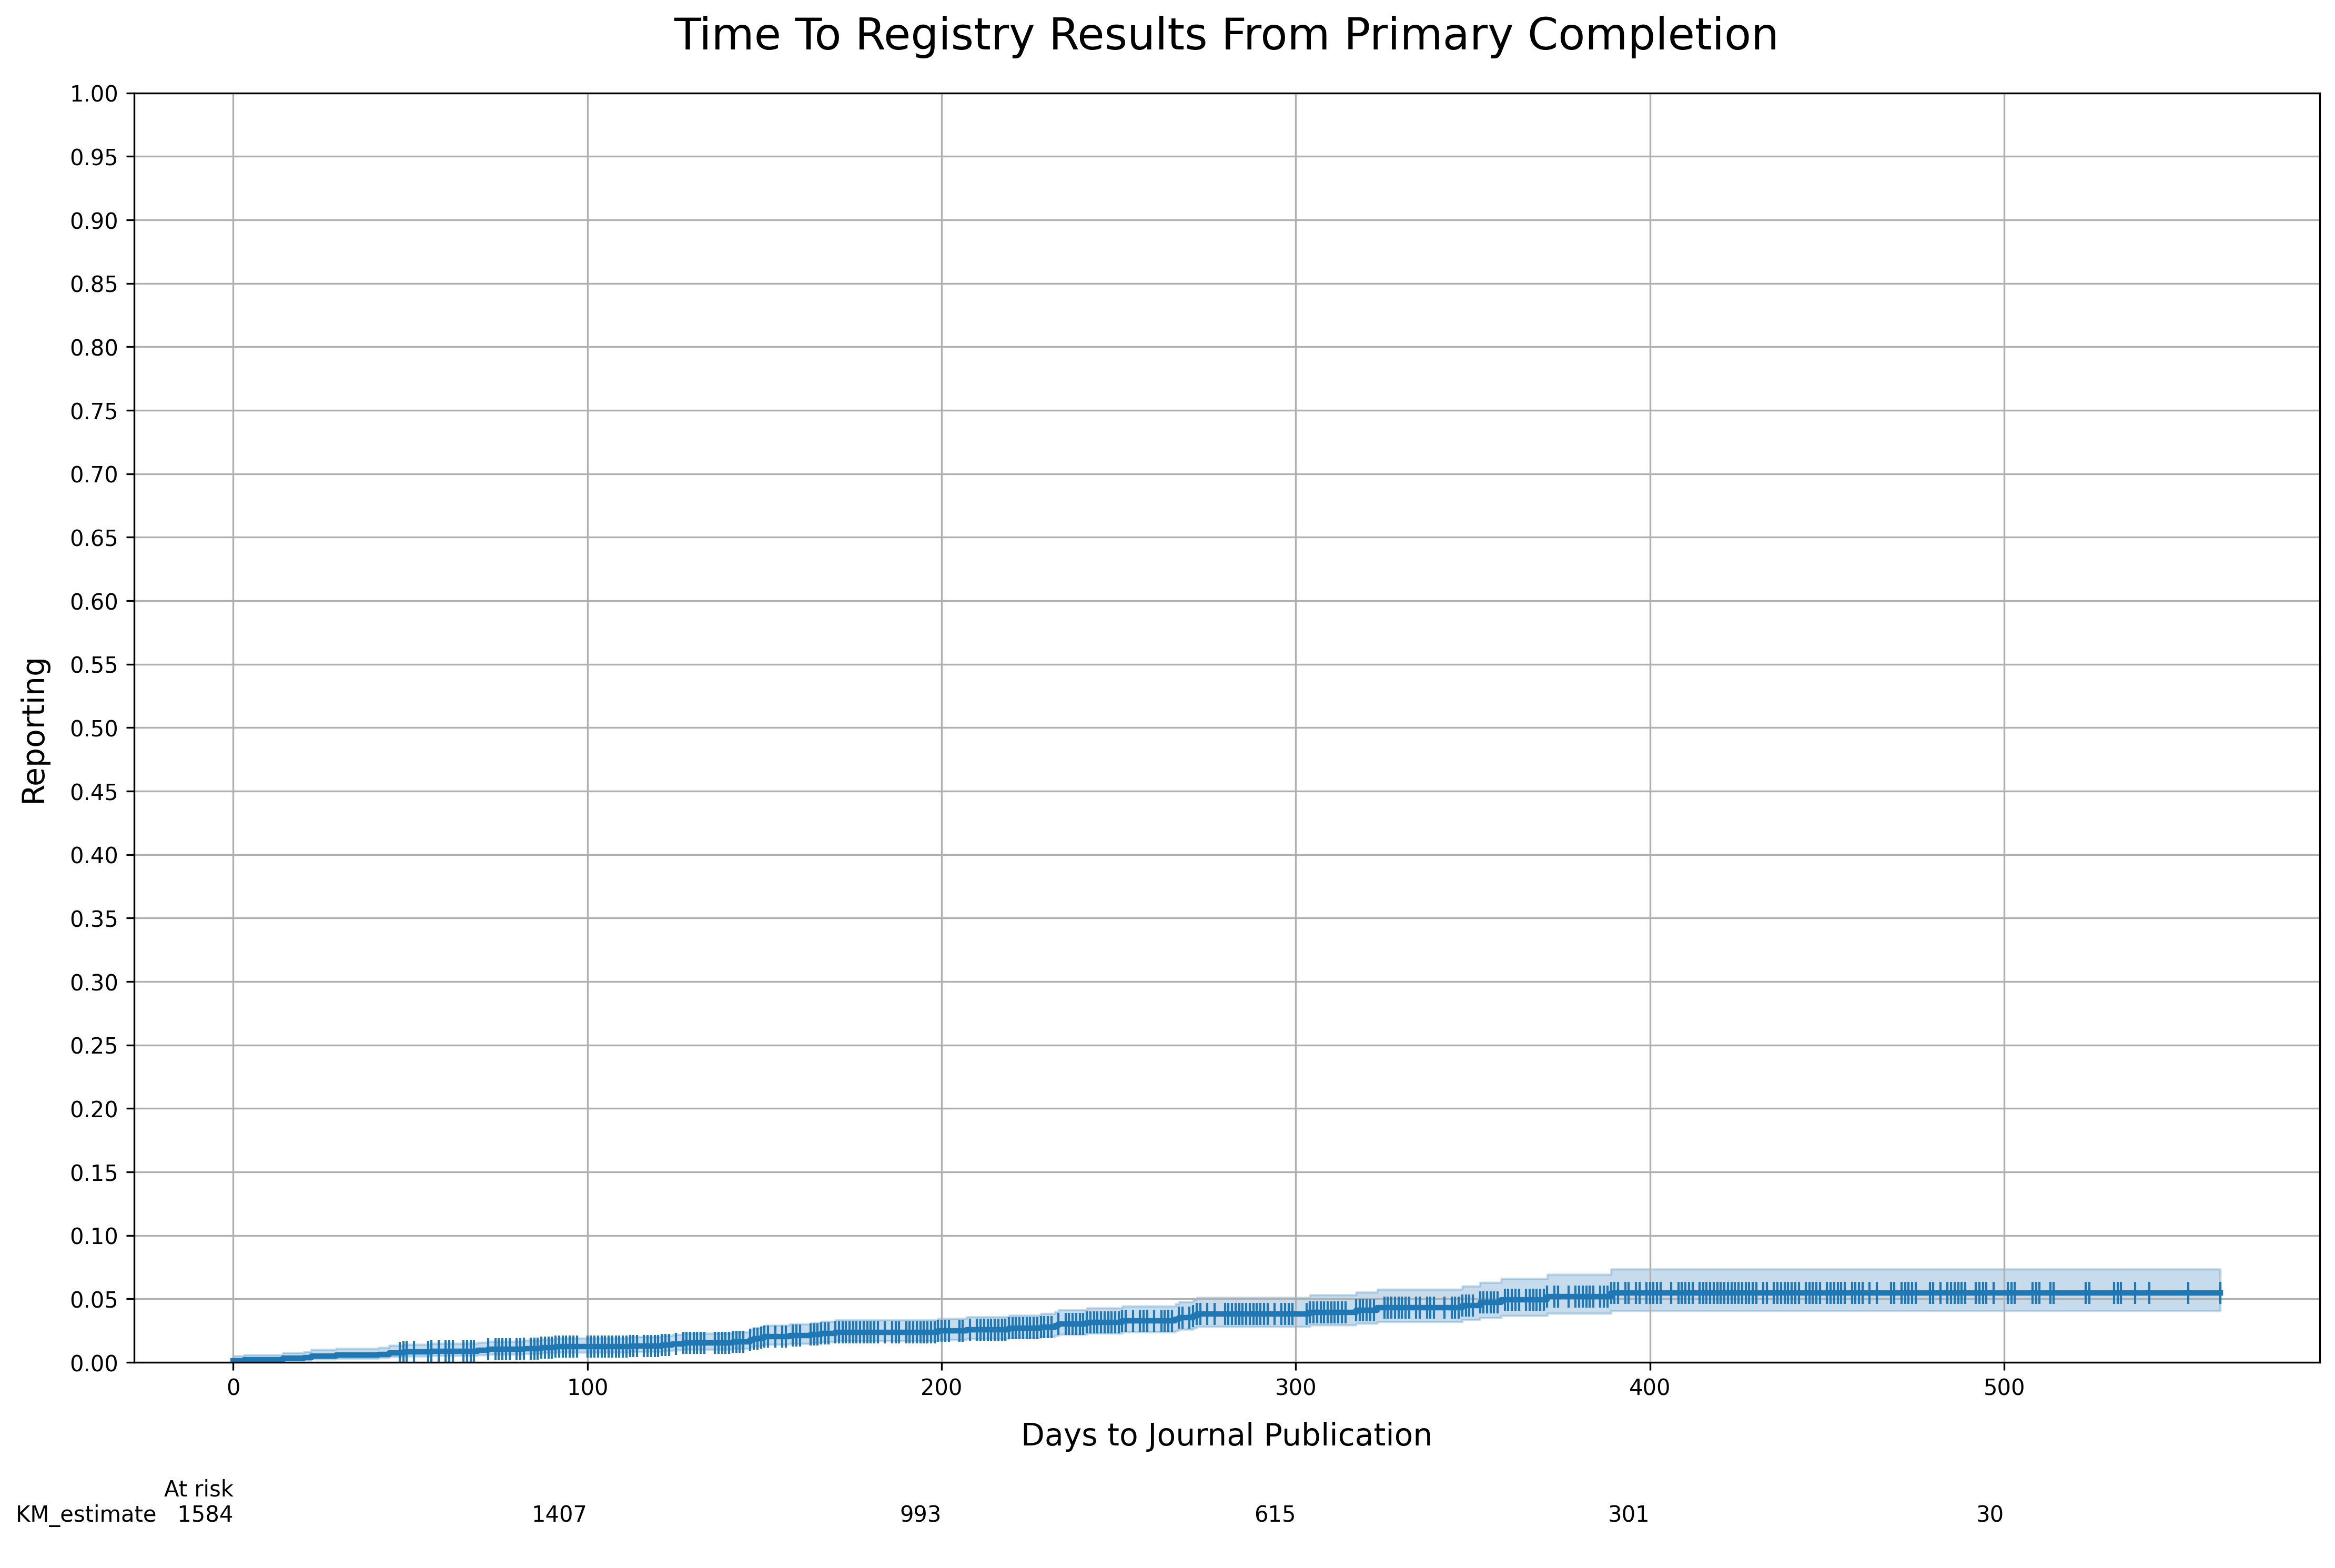

In [43]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T = reg_pub.time_publication_summary_adj
E = reg_pub.publication_summary_adj

kmf_article = KaplanMeierFitter()
kmf_article.fit(T, E)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_article.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)

ax.set_ylim([0, 1])

plt.title("Time To Registry Results From Primary Completion", pad=20, fontsize=20)
plt.ylabel('Reporting', labelpad=10, fontsize=14)
plt.xlabel('Days to Journal Publication', labelpad=10, fontsize=14)

add_at_risk_counts(kmf_article, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

# Venn

In [44]:
venn_data = df2[['publication_preprint_adj', 'publication_article_adj', 'publication_summary_adj']].reset_index(drop=True)

In [45]:
prep = venn_data.publication_preprint_adj == True
art = venn_data.publication_article_adj == True
reg = venn_data.publication_summary_adj == True

In [46]:
len(venn_data[~art & prep & reg])

5

In [47]:
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
labels = ['Journal Articles', 'Registry Results', 'Preprints']
values = (167, 19, 20, 96, 79, 5, 10)

Text(0.5, 1.0, 'COVID-19 Clinical Trial Results by Dissemination Route')

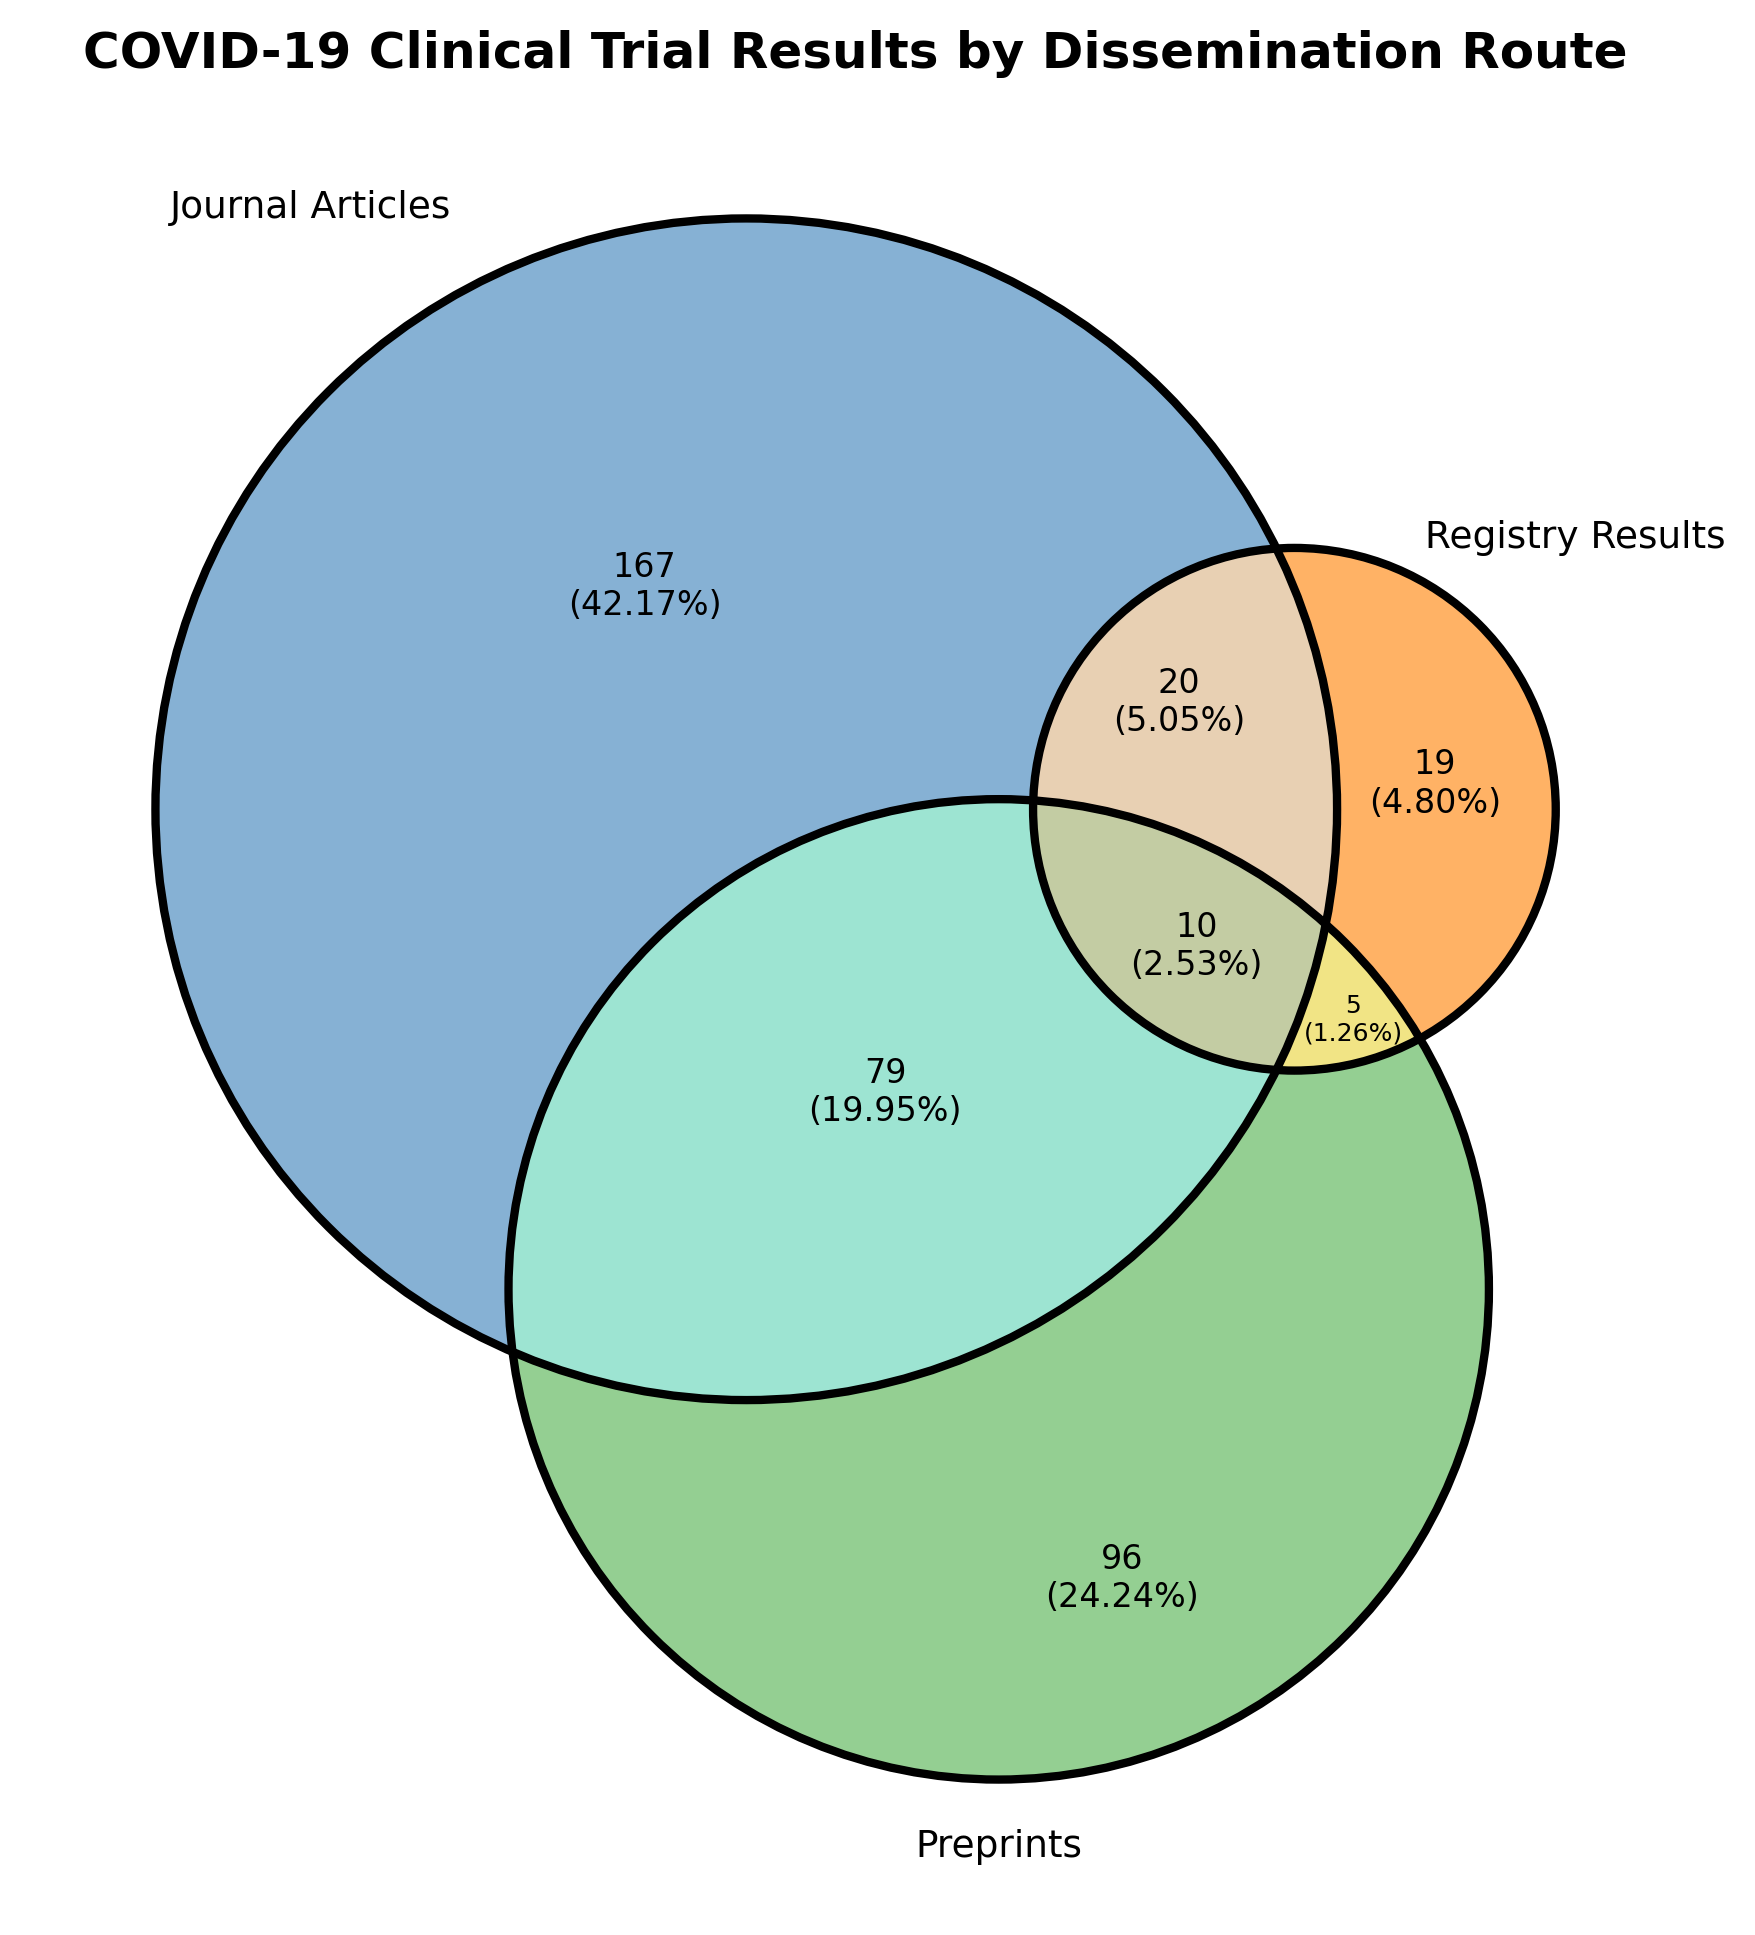

In [48]:
plt.figure(figsize=(8,8), dpi=300)
v1 = venn3(
    subsets = values, 
    set_labels = labels,
    set_colors = colors, 
    subset_label_formatter = lambda x: str(x) + "\n(" + f"{(x/sum(values)):1.2%}" + ")", 
    alpha = .6)

for text in v1.set_labels:
    text.set_fontsize(9)

for text in v1.subset_labels:
    if text == v1.subset_labels[5]:
        text.set_fontsize(6)
    else:
        text.set_fontsize(8)

v1.get_label_by_id("100").set_x(-0.2)
v1.get_label_by_id("111").set_x(.24)
v1.get_label_by_id("011").set_y(-.028)
v1.get_label_by_id("011").set_x(.365)
v1.get_label_by_id("010").set_x(.43)
v1.get_label_by_id("010").set_y(.16)

venn3_circles((167, 19, 20, 96, 79, 5, 10))
plt.title('COVID-19 Clinical Trial Results by Dissemination Route', fontweight='bold')

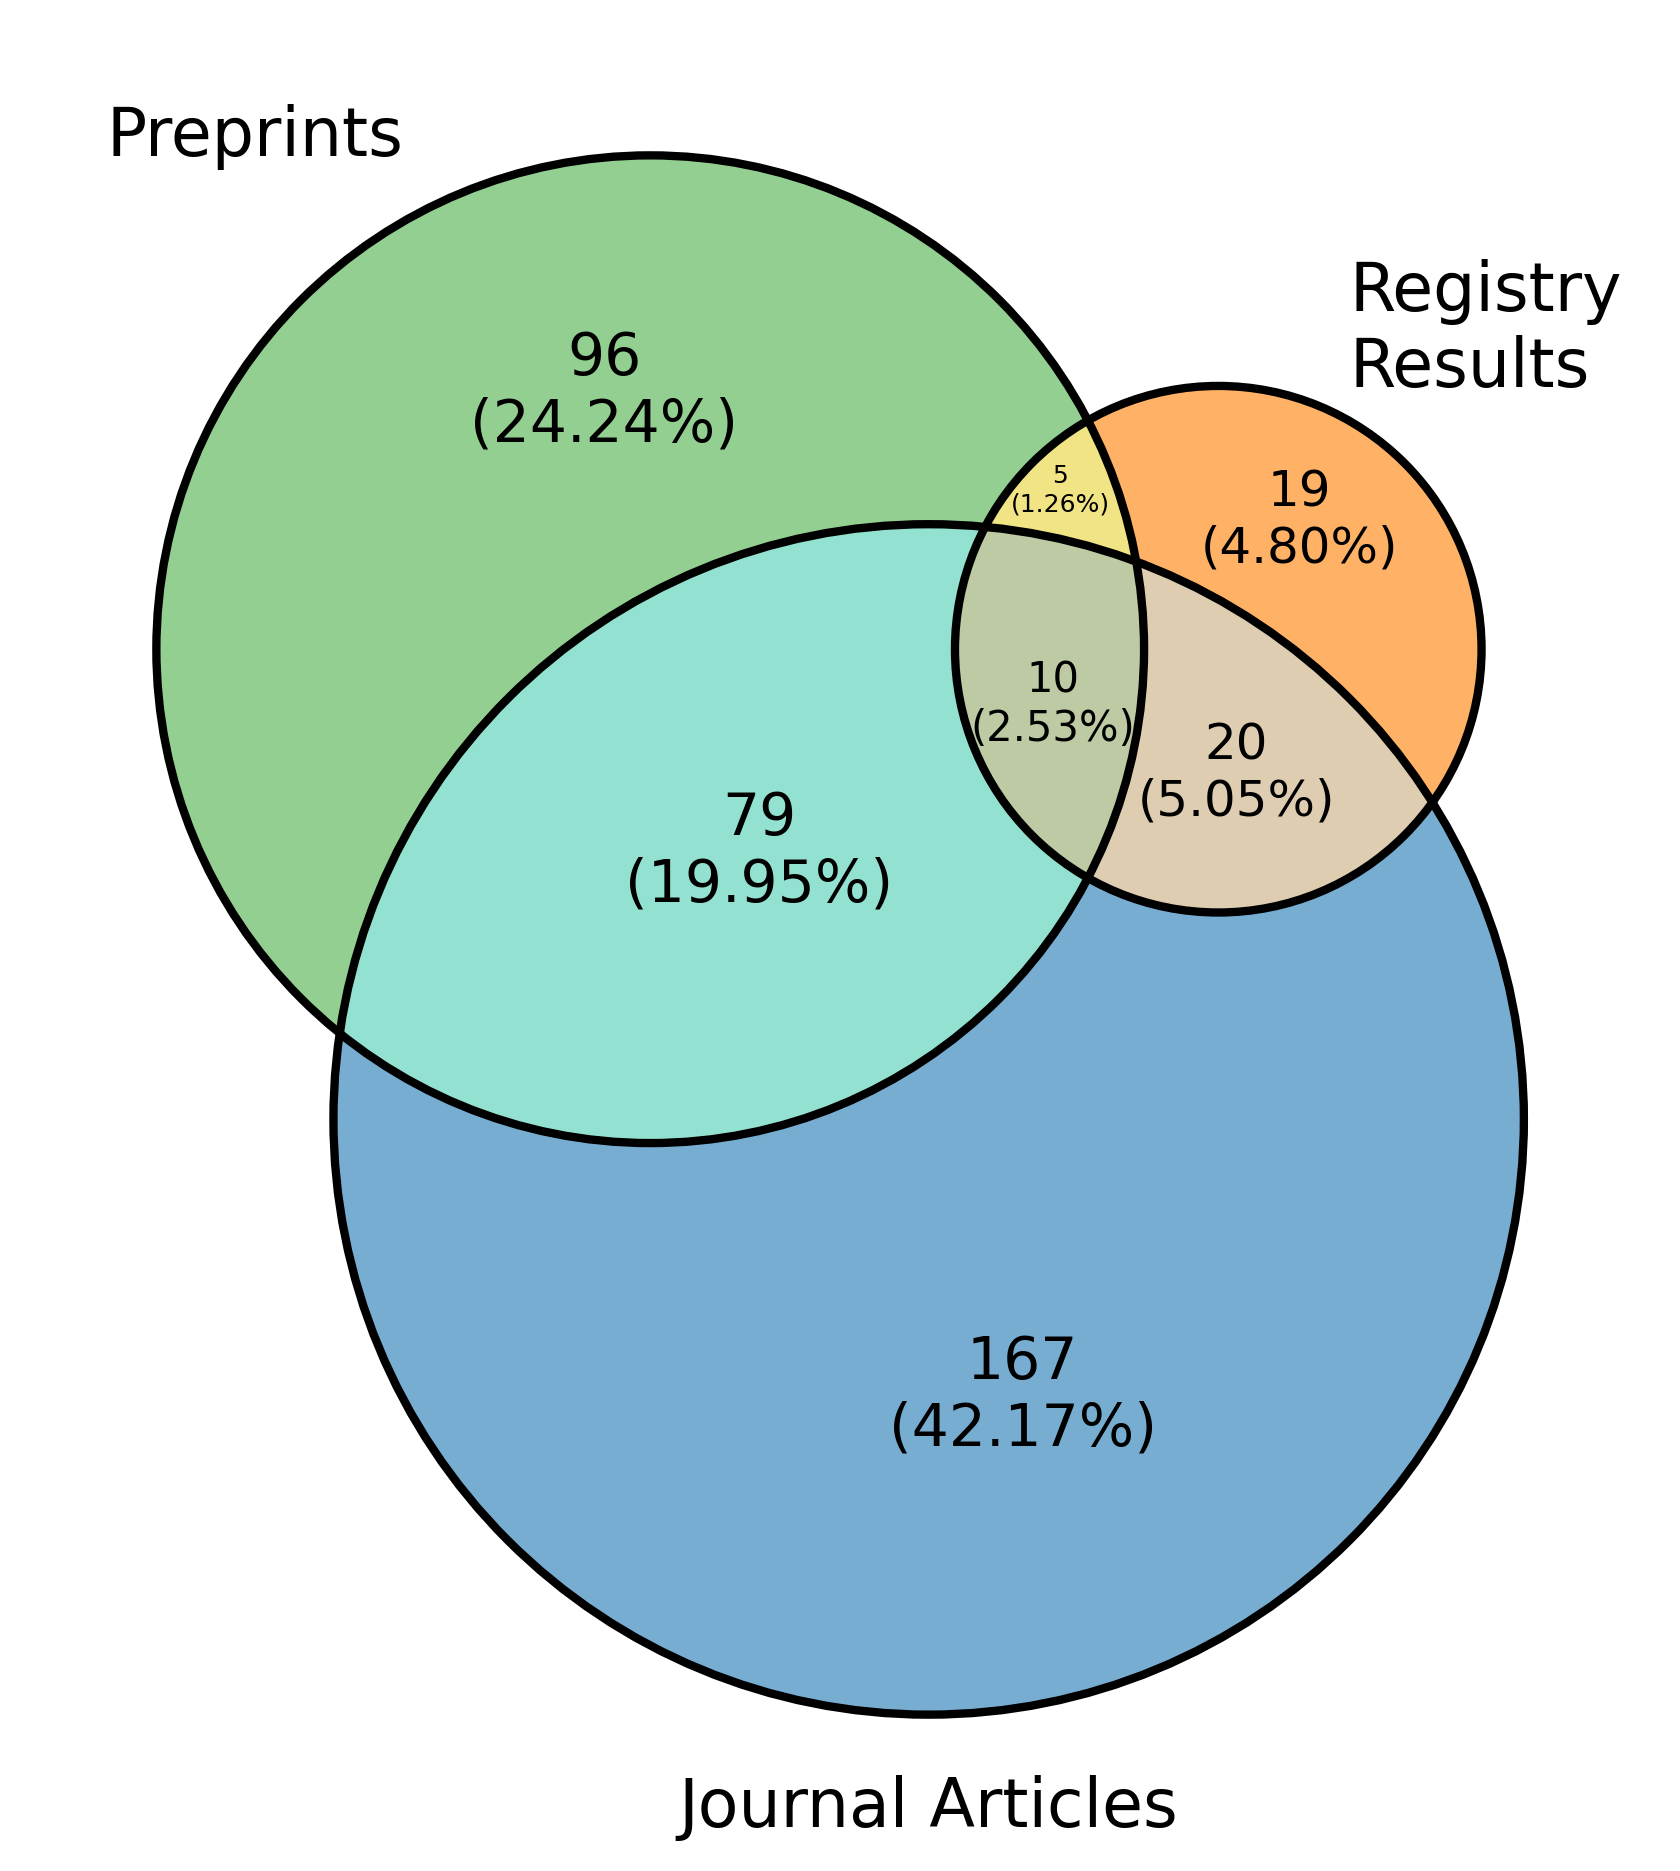

In [117]:
colors = ['#4daf4a', '#ff7f00', '#1f77b4']
labels = ['Preprints', 'Registry\nResults', 'Journal Articles']
values = (96, 19, 5, 167, 79, 20, 10)

plt.figure(figsize=(8,8), dpi=300)
v1 = venn3(
    subsets = values, 
    set_labels = labels,
    set_colors = colors, 
    subset_label_formatter = lambda x: str(x) + "\n(" + f"{(x/sum(values)):1.2%}" + ")", 
    alpha = .6)

for text in v1.set_labels:
    text.set_fontsize(16)

for text in v1.subset_labels:
    if text == v1.subset_labels[2]:
        text.set_fontsize(6)
    elif text == v1.subset_labels[-1]:
        text.set_fontsize(10)
    elif text == v1.subset_labels[1] or text == v1.subset_labels[5]:
        text.set_fontsize(12)
    else:
        text.set_fontsize(14)

v1.get_label_by_id("100").set_x(-0.2)
v1.get_label_by_id("111").set_x(.155)
v1.get_label_by_id("011").set_y(.1)
v1.get_label_by_id("011").set_x(.3)
v1.get_label_by_id("010").set_x(.35)
v1.get_label_by_id("010").set_y(.3)

venn3_circles((96, 19, 5, 167, 79, 20, 10))
#plt.title('COVID-19 Clinical Trial Results by Dissemination Route', fontweight='bold')
plt.show()

# Breaking Pandemic into Phases

In [49]:
phase_1 = pd.to_datetime('2020-06-30')
phase_2 = pd.to_datetime('2020-12-31')
phase_3 = pd.to_datetime('2021-06-30')


date_conds = [(df2.date_completion <= phase_1), 
              (df2.date_completion > phase_1) & (df2.date_completion <= phase_2),
              (df2.date_completion > phase_2) & (df2.date_completion <= phase_3)]

date_out = [1,2,3]

df2['pandemic_phase'] = np.select(date_conds, date_out)

In [50]:
#What does this look like for reporting

In [51]:
phase_pub = df2[['publication_any_adj', 'time_reporting_any_adj', 'pandemic_phase']].reset_index(drop=True)
phase_pub['publication_any_adj'] = phase_pub['publication_any_adj'].astype(int)
phase_pub['time_reporting_any_adj'] = np.where(phase_pub['time_reporting_any_adj'] < 0, 0, phase_pub['time_reporting_any_adj'])

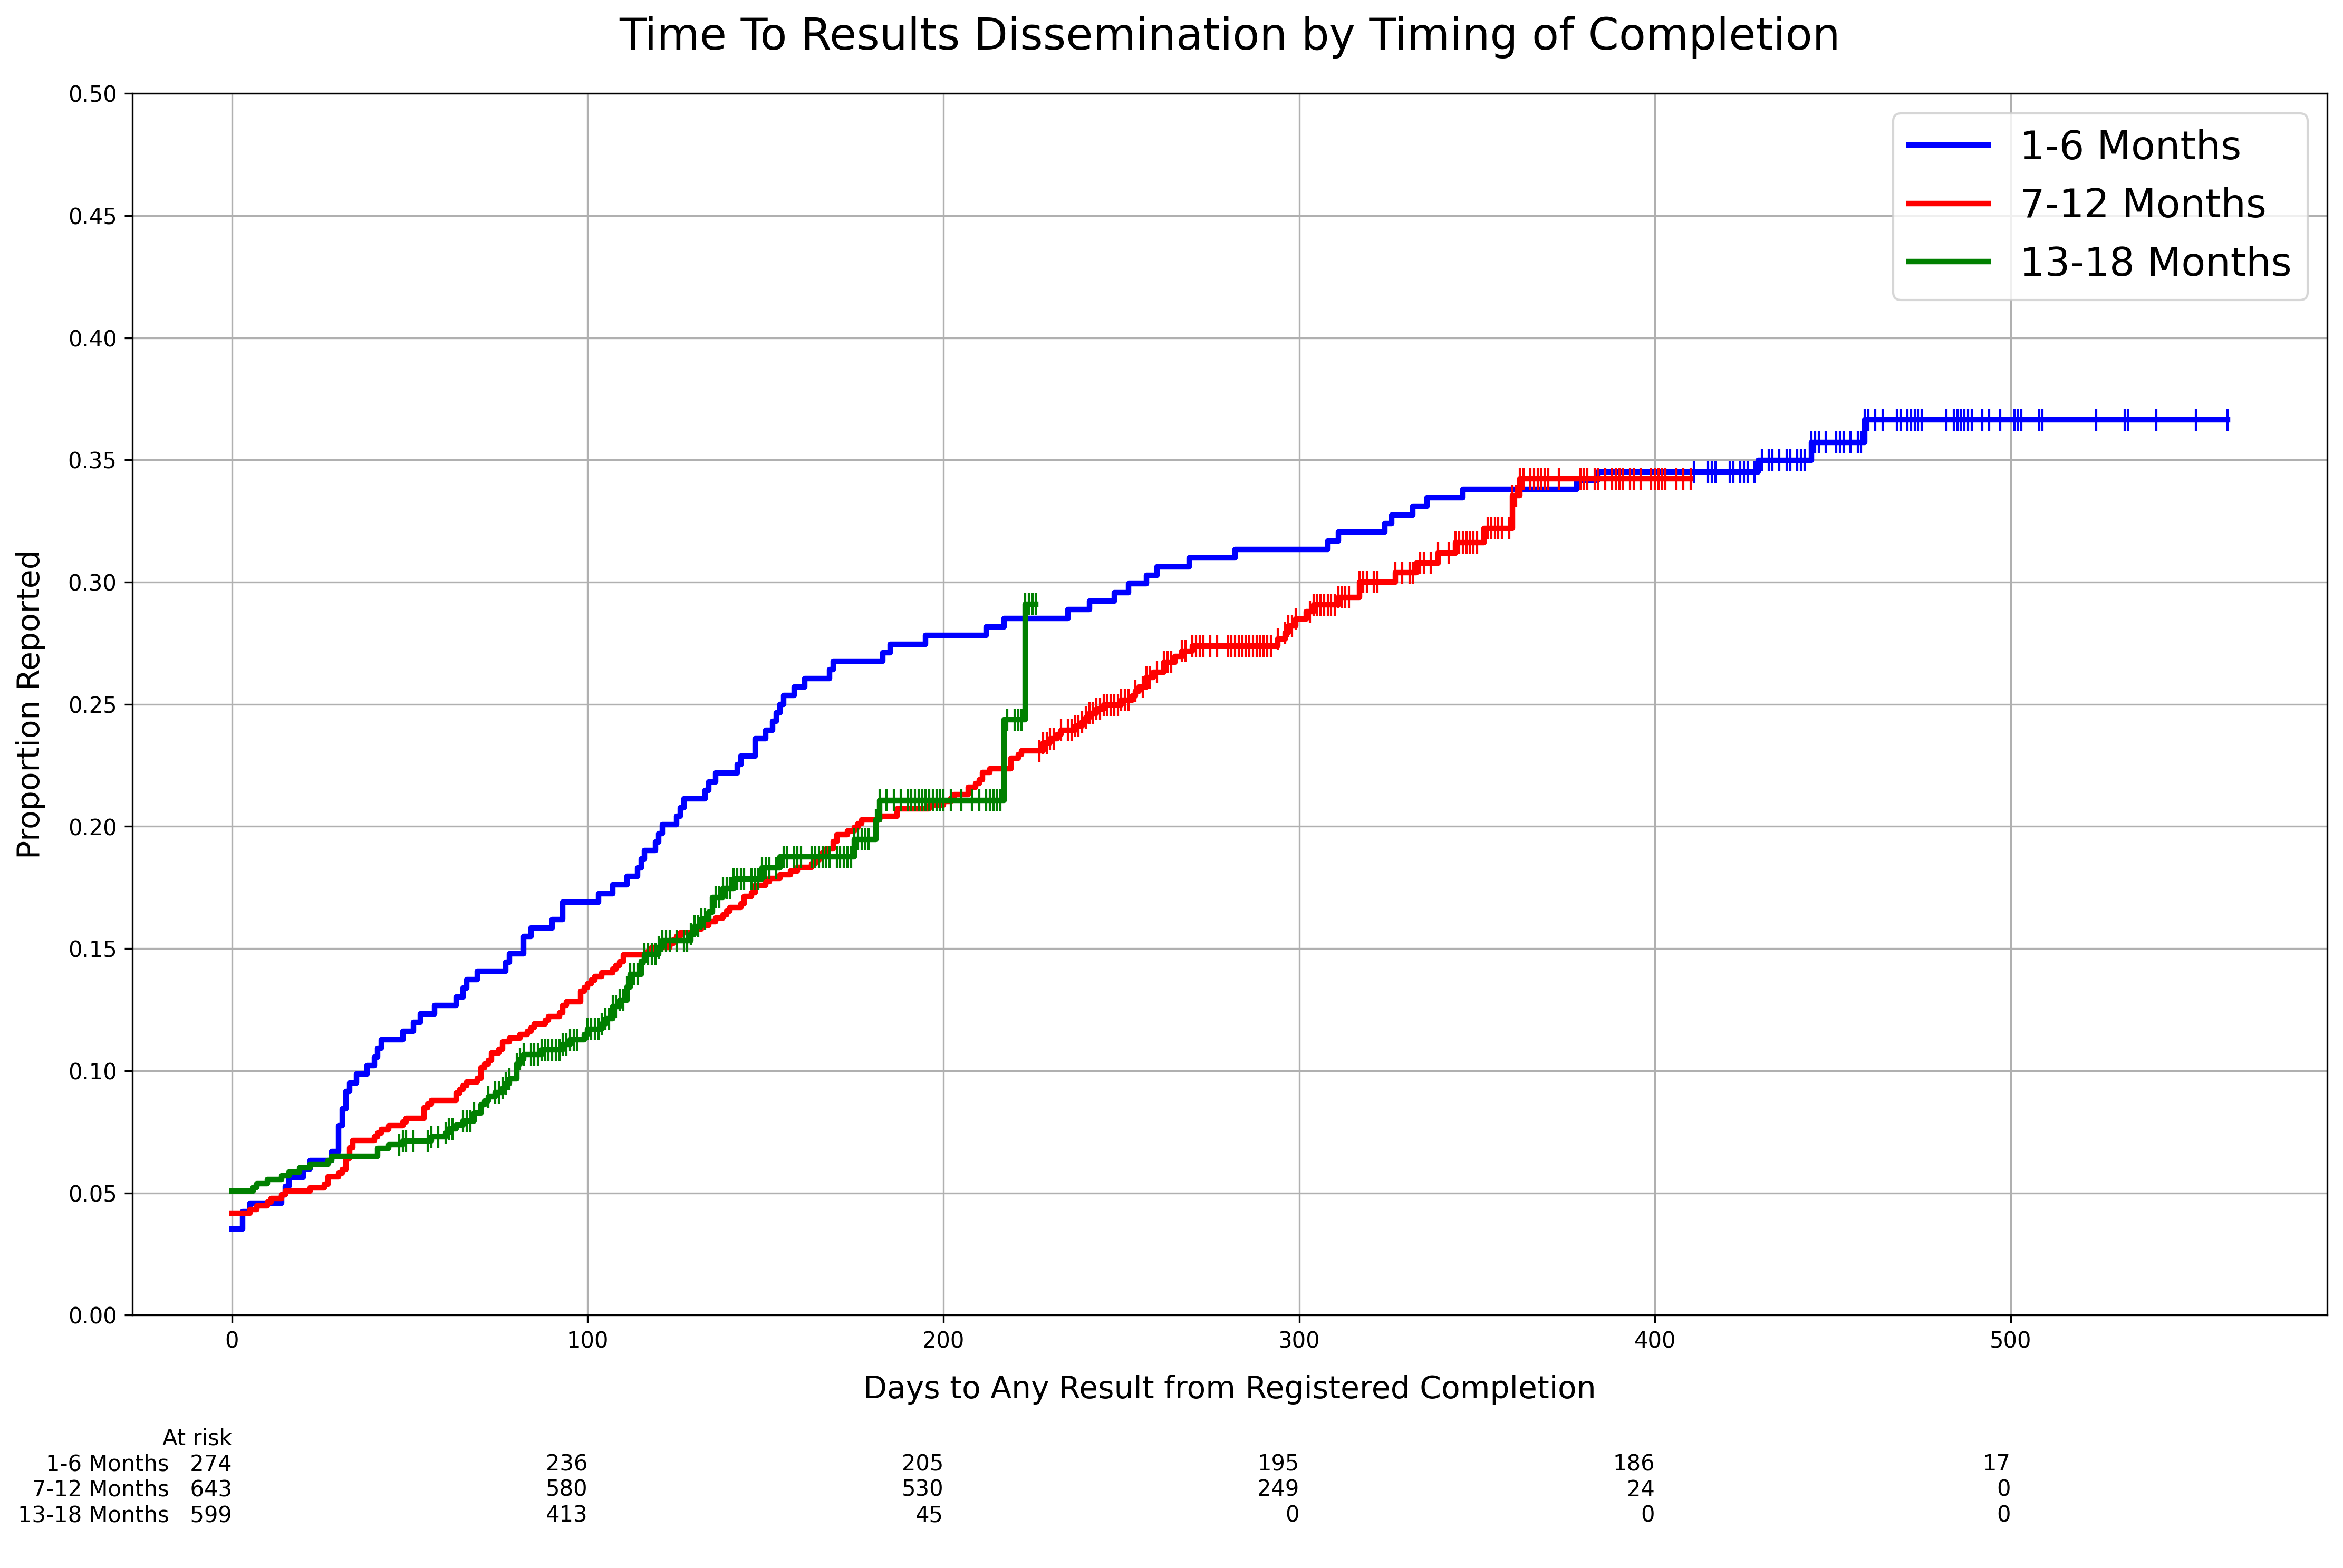

In [52]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T1 = phase_pub[phase_pub.pandemic_phase == 1].time_reporting_any_adj
E1 = phase_pub[phase_pub.pandemic_phase == 1].publication_any_adj

kmf_1 = KaplanMeierFitter()
kmf_1.fit(T1, E1, label='1-6 Months')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_1.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='blue')

T2 = phase_pub[phase_pub.pandemic_phase == 2].time_reporting_any_adj
E2 = phase_pub[phase_pub.pandemic_phase == 2].publication_any_adj

kmf_2 = KaplanMeierFitter()
kmf_2.fit(T2, E2, label='7-12 Months')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_2.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='red')


T3 = phase_pub[phase_pub.pandemic_phase == 3].time_reporting_any_adj
E3 = phase_pub[phase_pub.pandemic_phase == 3].publication_any_adj

kmf_3 = KaplanMeierFitter()
kmf_3.fit(T3, E3, label='13-18 Months')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_3.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='green')

ax.set_ylim([0, .5])

plt.title("Time To Results Dissemination by Timing of Completion", pad=20, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Result from Registered Completion', labelpad=10, fontsize=14)
ax.legend(fontsize = 18)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_1, kmf_2, kmf_3, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

In [53]:
phase_pub[phase_pub.pandemic_phase == 3].to_csv('temp_phase3.csv')

# Interventions

In [54]:
df_int = df2.copy()

In [55]:
int_data = pd.read_csv(parent + '/data/interventions/common_ints.csv')

In [56]:
int_merge = df_int.merge(int_data, how='left', left_on='id', right_on='db_id')

In [57]:
hcq = int_merge[int_merge.HCQ > 0]
ive = int_merge[int_merge.IVE > 0]
cp = int_merge[int_merge.CP > 0]

In [58]:
len(hcq)

139

In [59]:
len(ive)

45

In [60]:
len(cp)

114

In [61]:
hcq_pub = hcq[['publication_any_adj', 'time_reporting_any_adj']].reset_index(drop=True)
hcq_pub['publication_any_adj'] = hcq_pub['publication_any_adj'].astype(int)
hcq_pub['time_reporting_any_adj'] = np.where(hcq_pub['time_reporting_any_adj'] < 0, 0, hcq_pub['time_reporting_any_adj'])

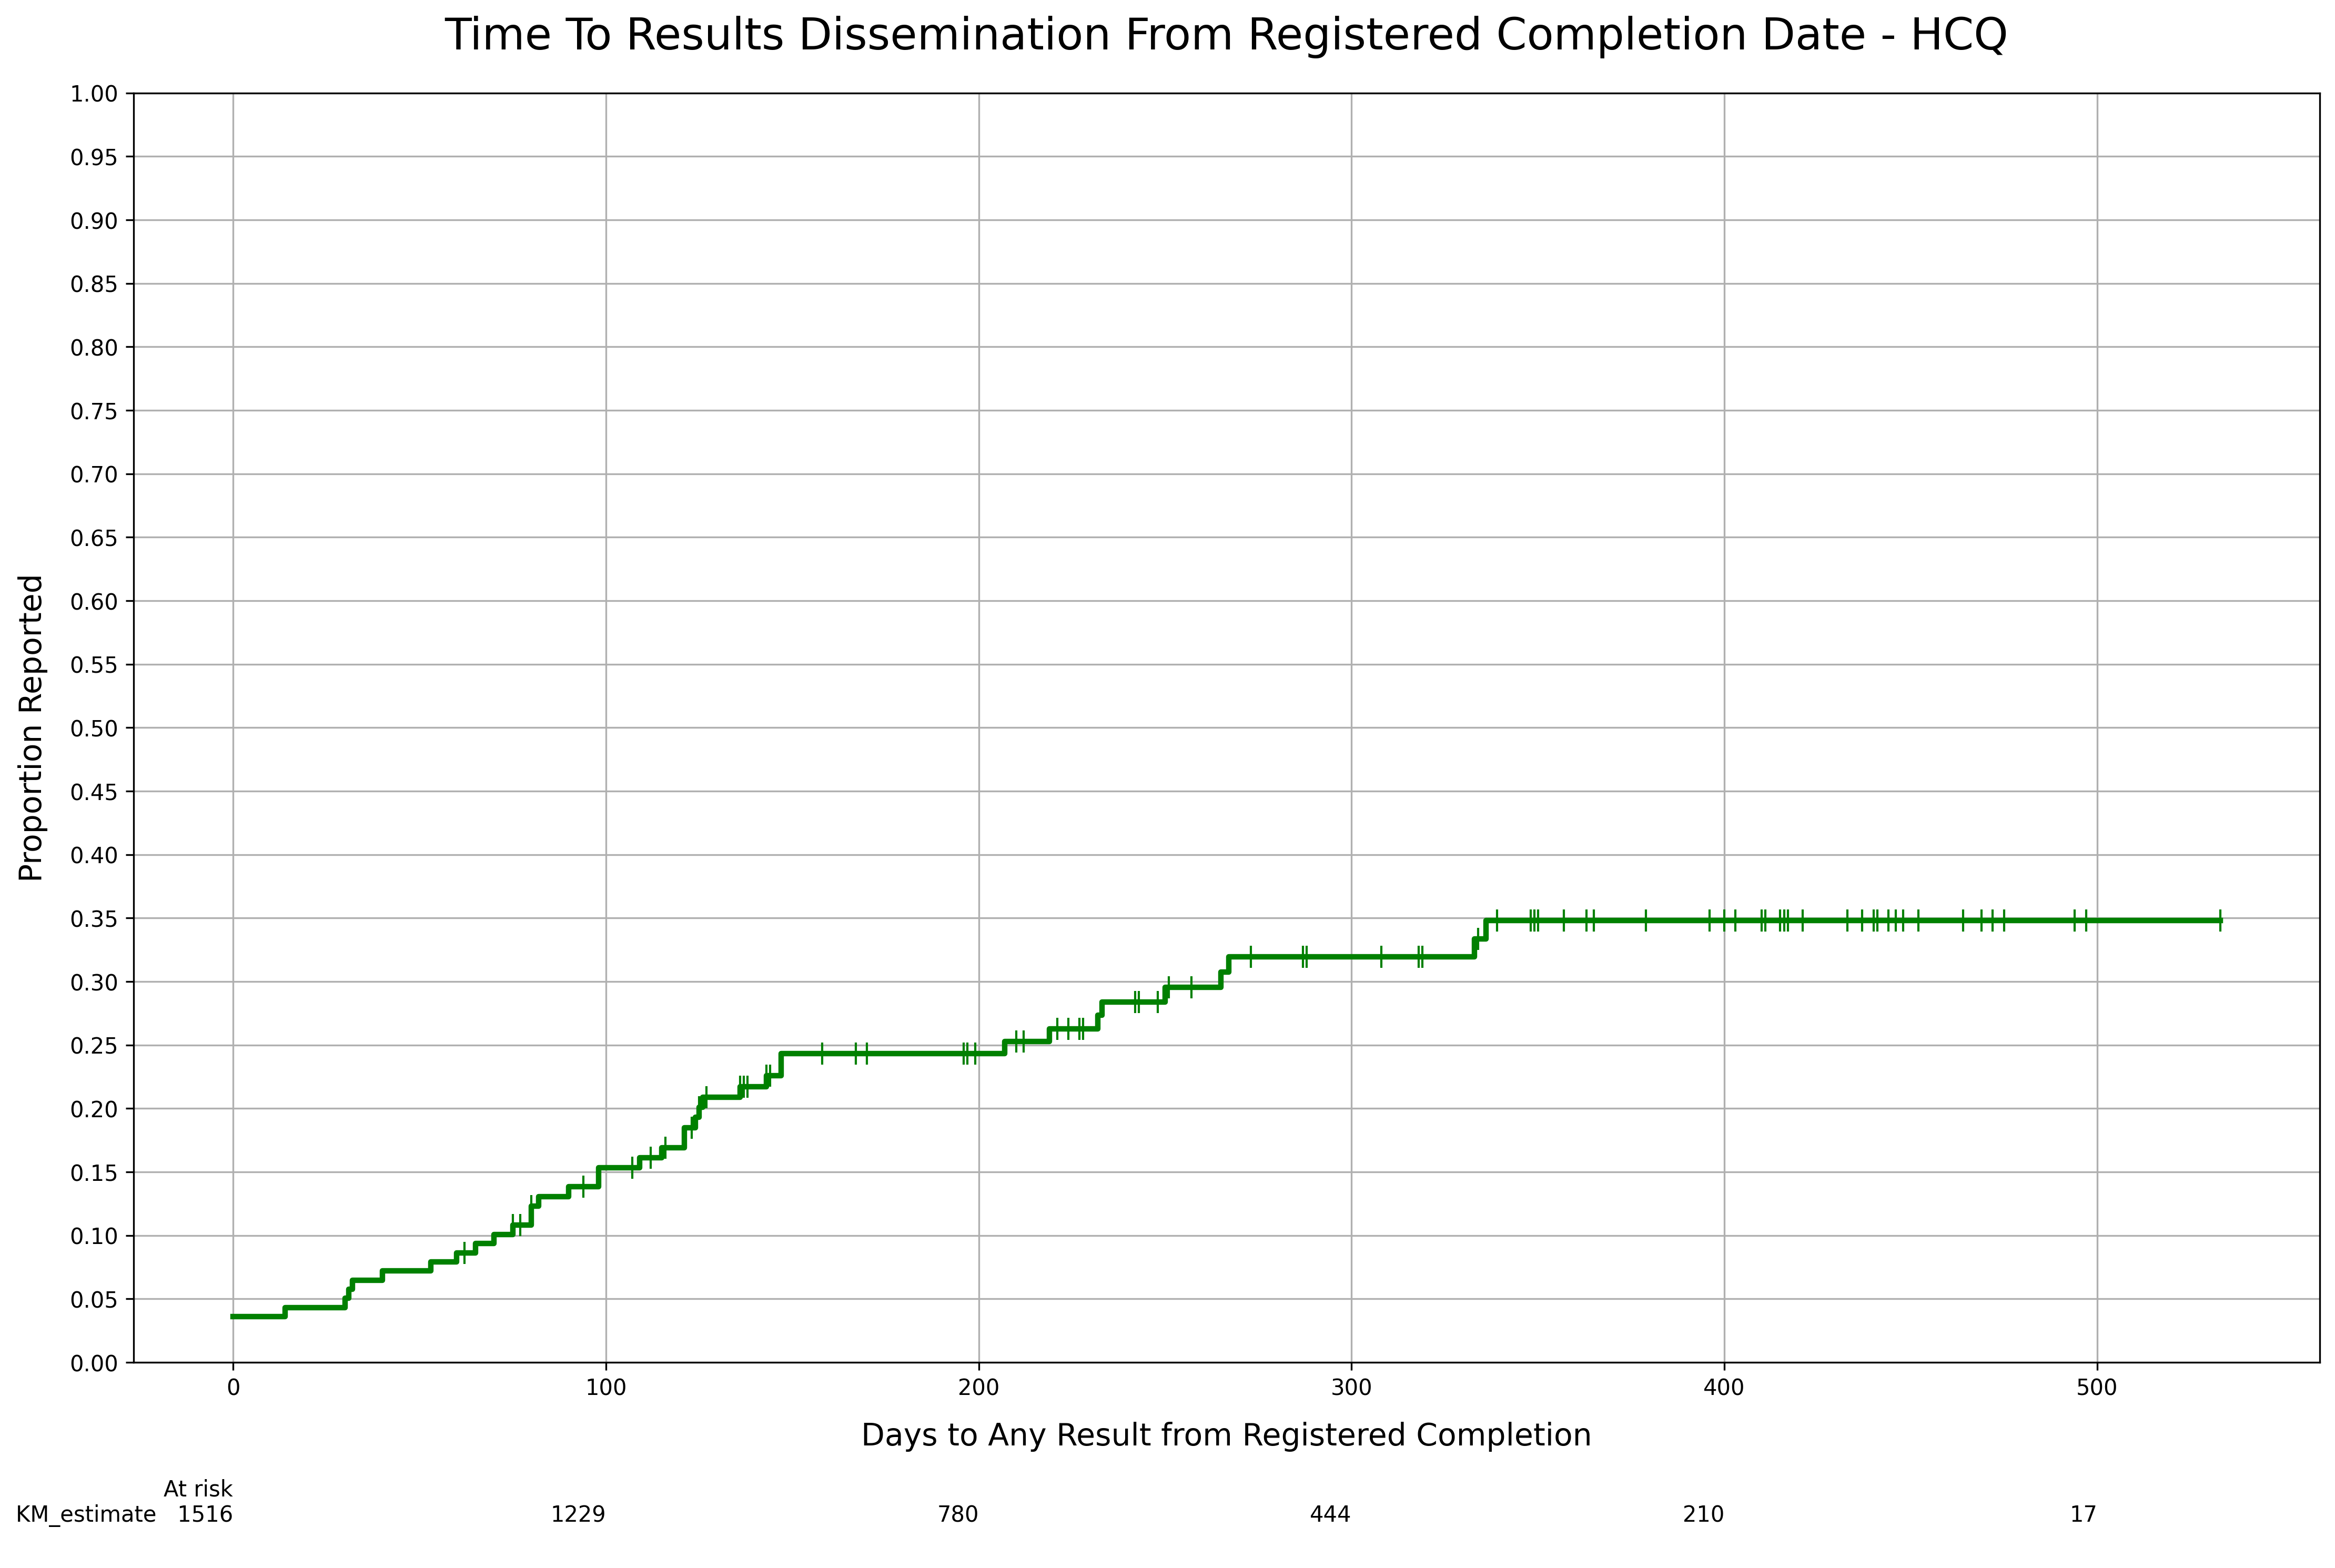

In [62]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T_hcq = hcq_pub.time_reporting_any_adj
E_hcq = hcq_pub.publication_any_adj

kmf_hcq = KaplanMeierFitter()
kmf_hcq.fit(T_hcq, E_hcq)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_hcq.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5, 
                                     color='green')

ax.set_ylim([0, 1])

plt.title("Time To Results Dissemination From Registered Completion Date - HCQ", pad=20, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Result from Registered Completion', labelpad=10, fontsize=14)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_any, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

In [63]:
ive_pub = ive[['publication_any_adj', 'time_reporting_any_adj']].reset_index(drop=True)
ive_pub['publication_any_adj'] = ive_pub['publication_any_adj'].astype(int)
ive_pub['time_reporting_any_adj'] = np.where(ive_pub['time_reporting_any_adj'] < 0, 0, ive_pub['time_reporting_any_adj'])

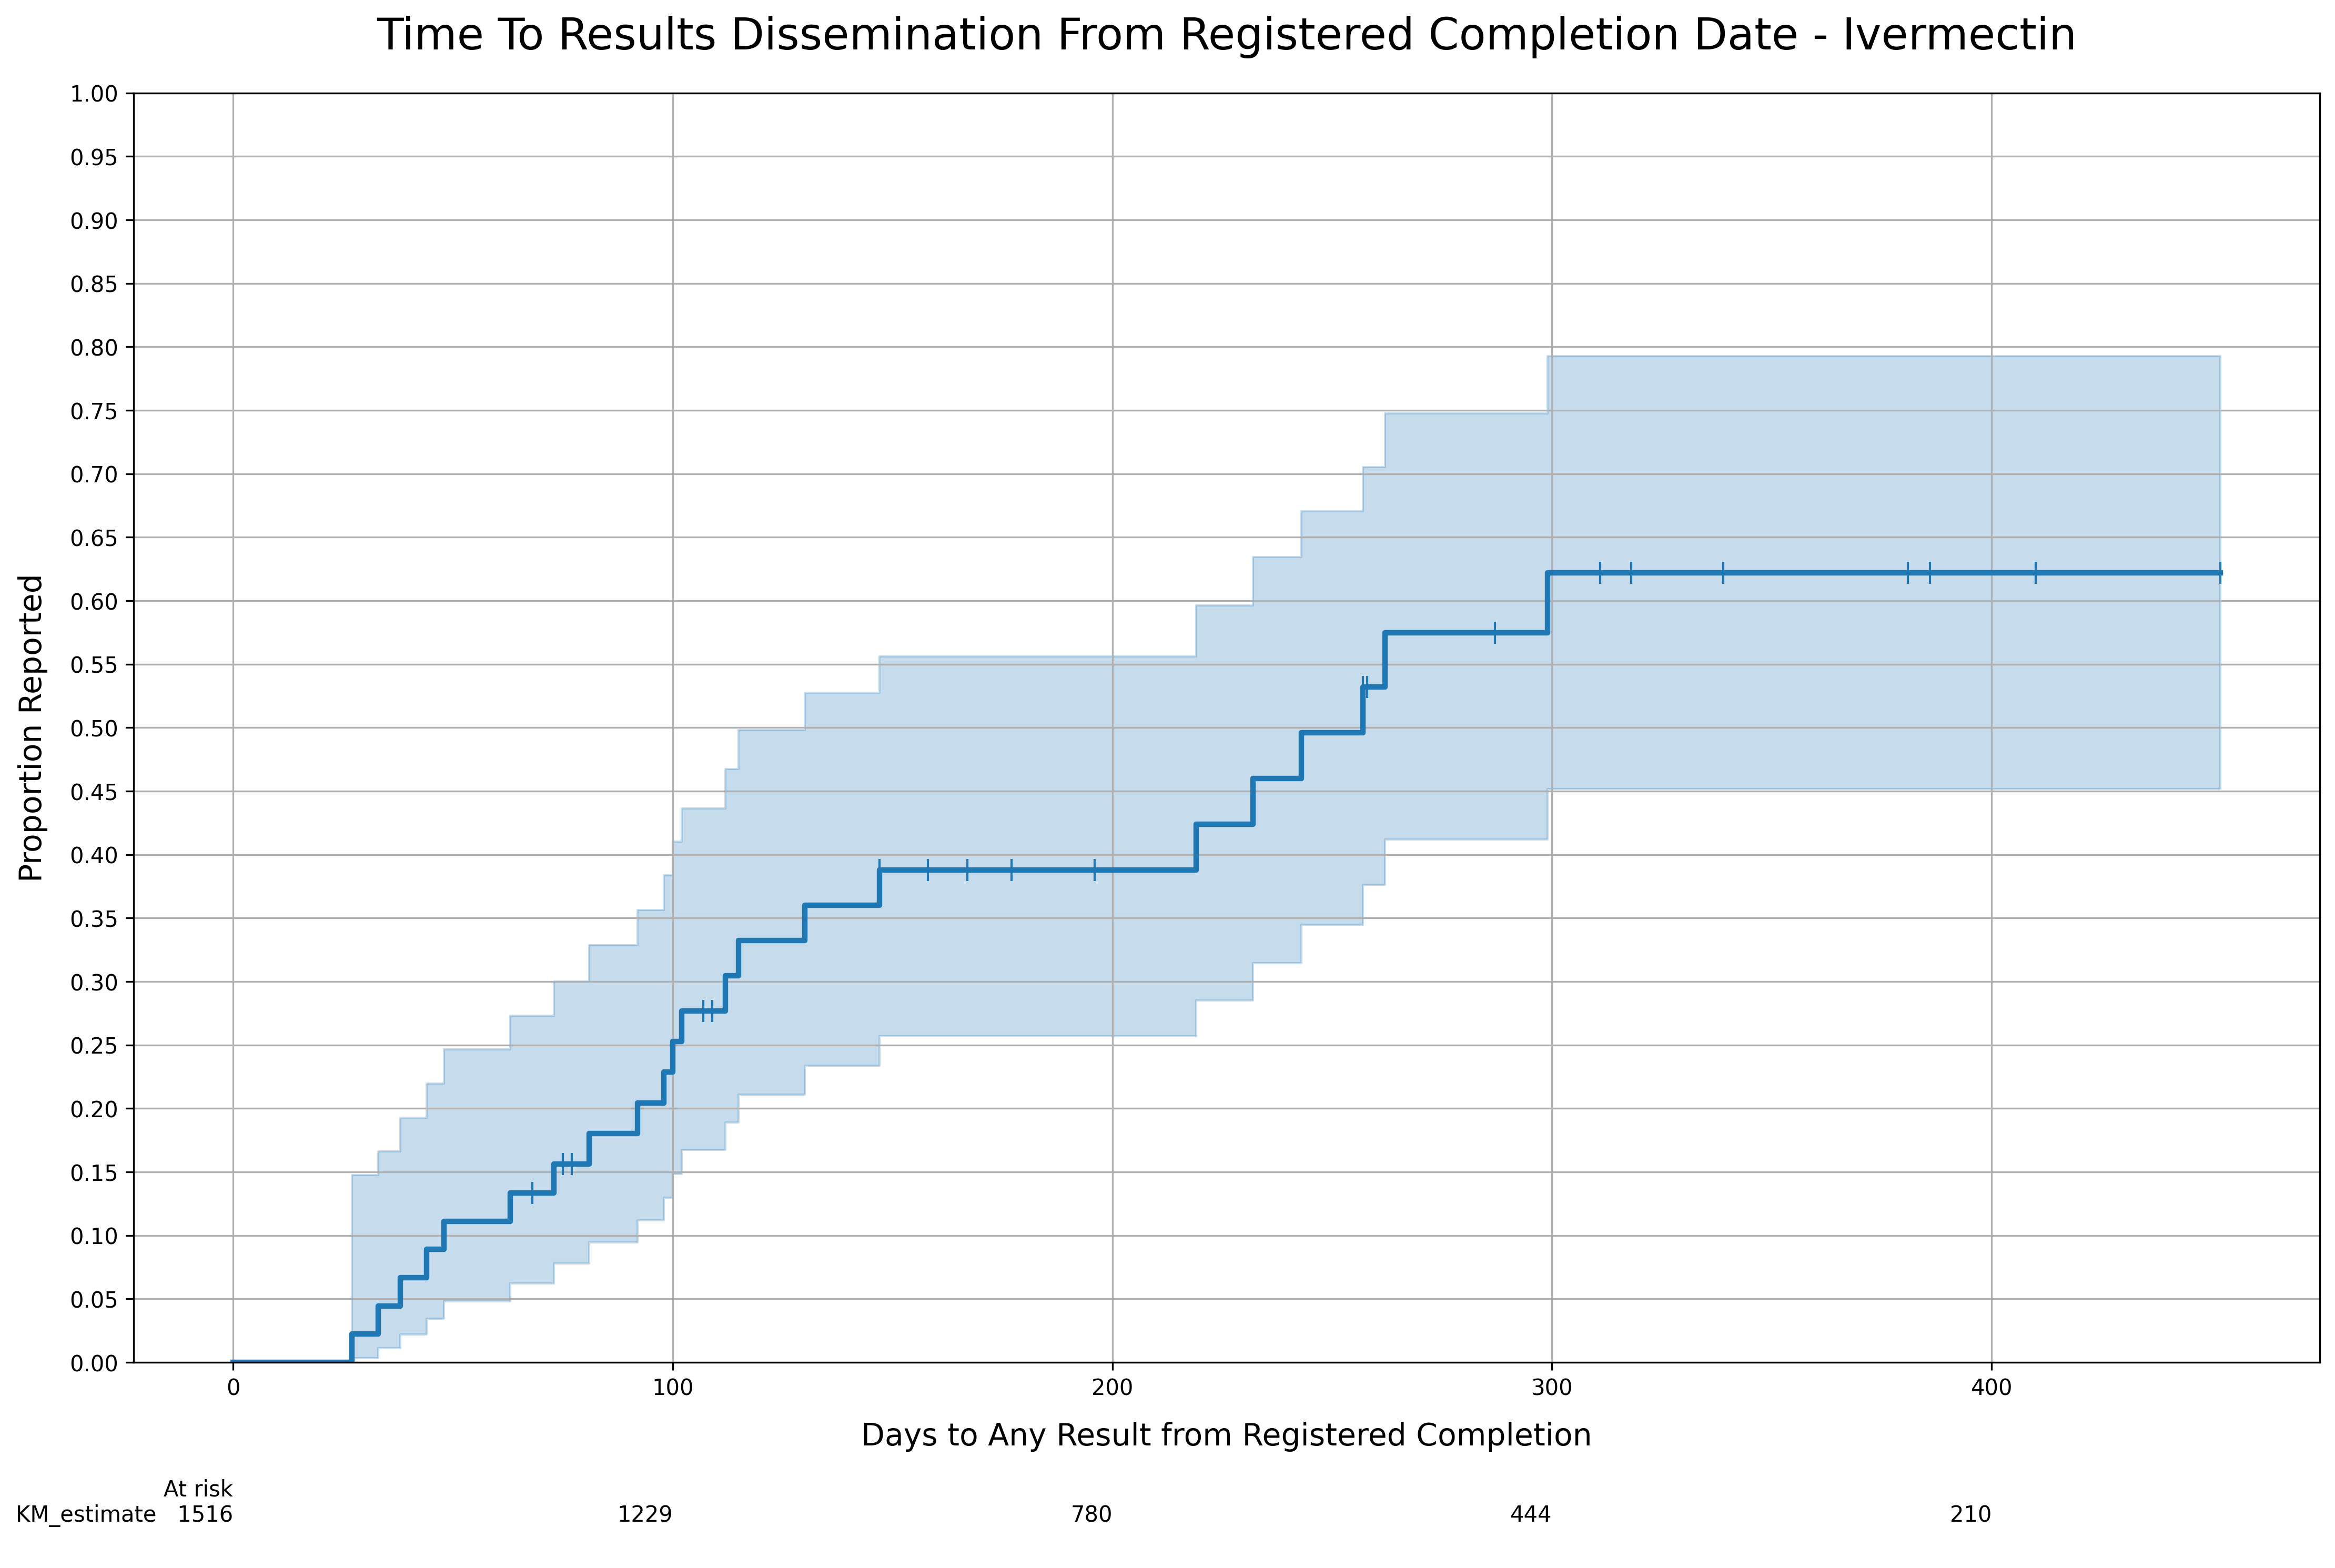

In [64]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T_ive = ive_pub.time_reporting_any_adj
E_ive = ive_pub.publication_any_adj

kmf_ive = KaplanMeierFitter()
kmf_ive.fit(T_ive, E_ive)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_ive.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)

ax.set_ylim([0, 1])

plt.title("Time To Results Dissemination From Registered Completion Date - Ivermectin", pad=20, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Result from Registered Completion', labelpad=10, fontsize=14)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_any, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

In [65]:
cp_pub = cp[['publication_any_adj', 'time_reporting_any_adj']].reset_index(drop=True)
cp_pub['publication_any_adj'] = cp_pub['publication_any_adj'].astype(int)
cp_pub['time_reporting_any_adj'] = np.where(cp_pub['time_reporting_any_adj'] < 0, 0, cp_pub['time_reporting_any_adj'])

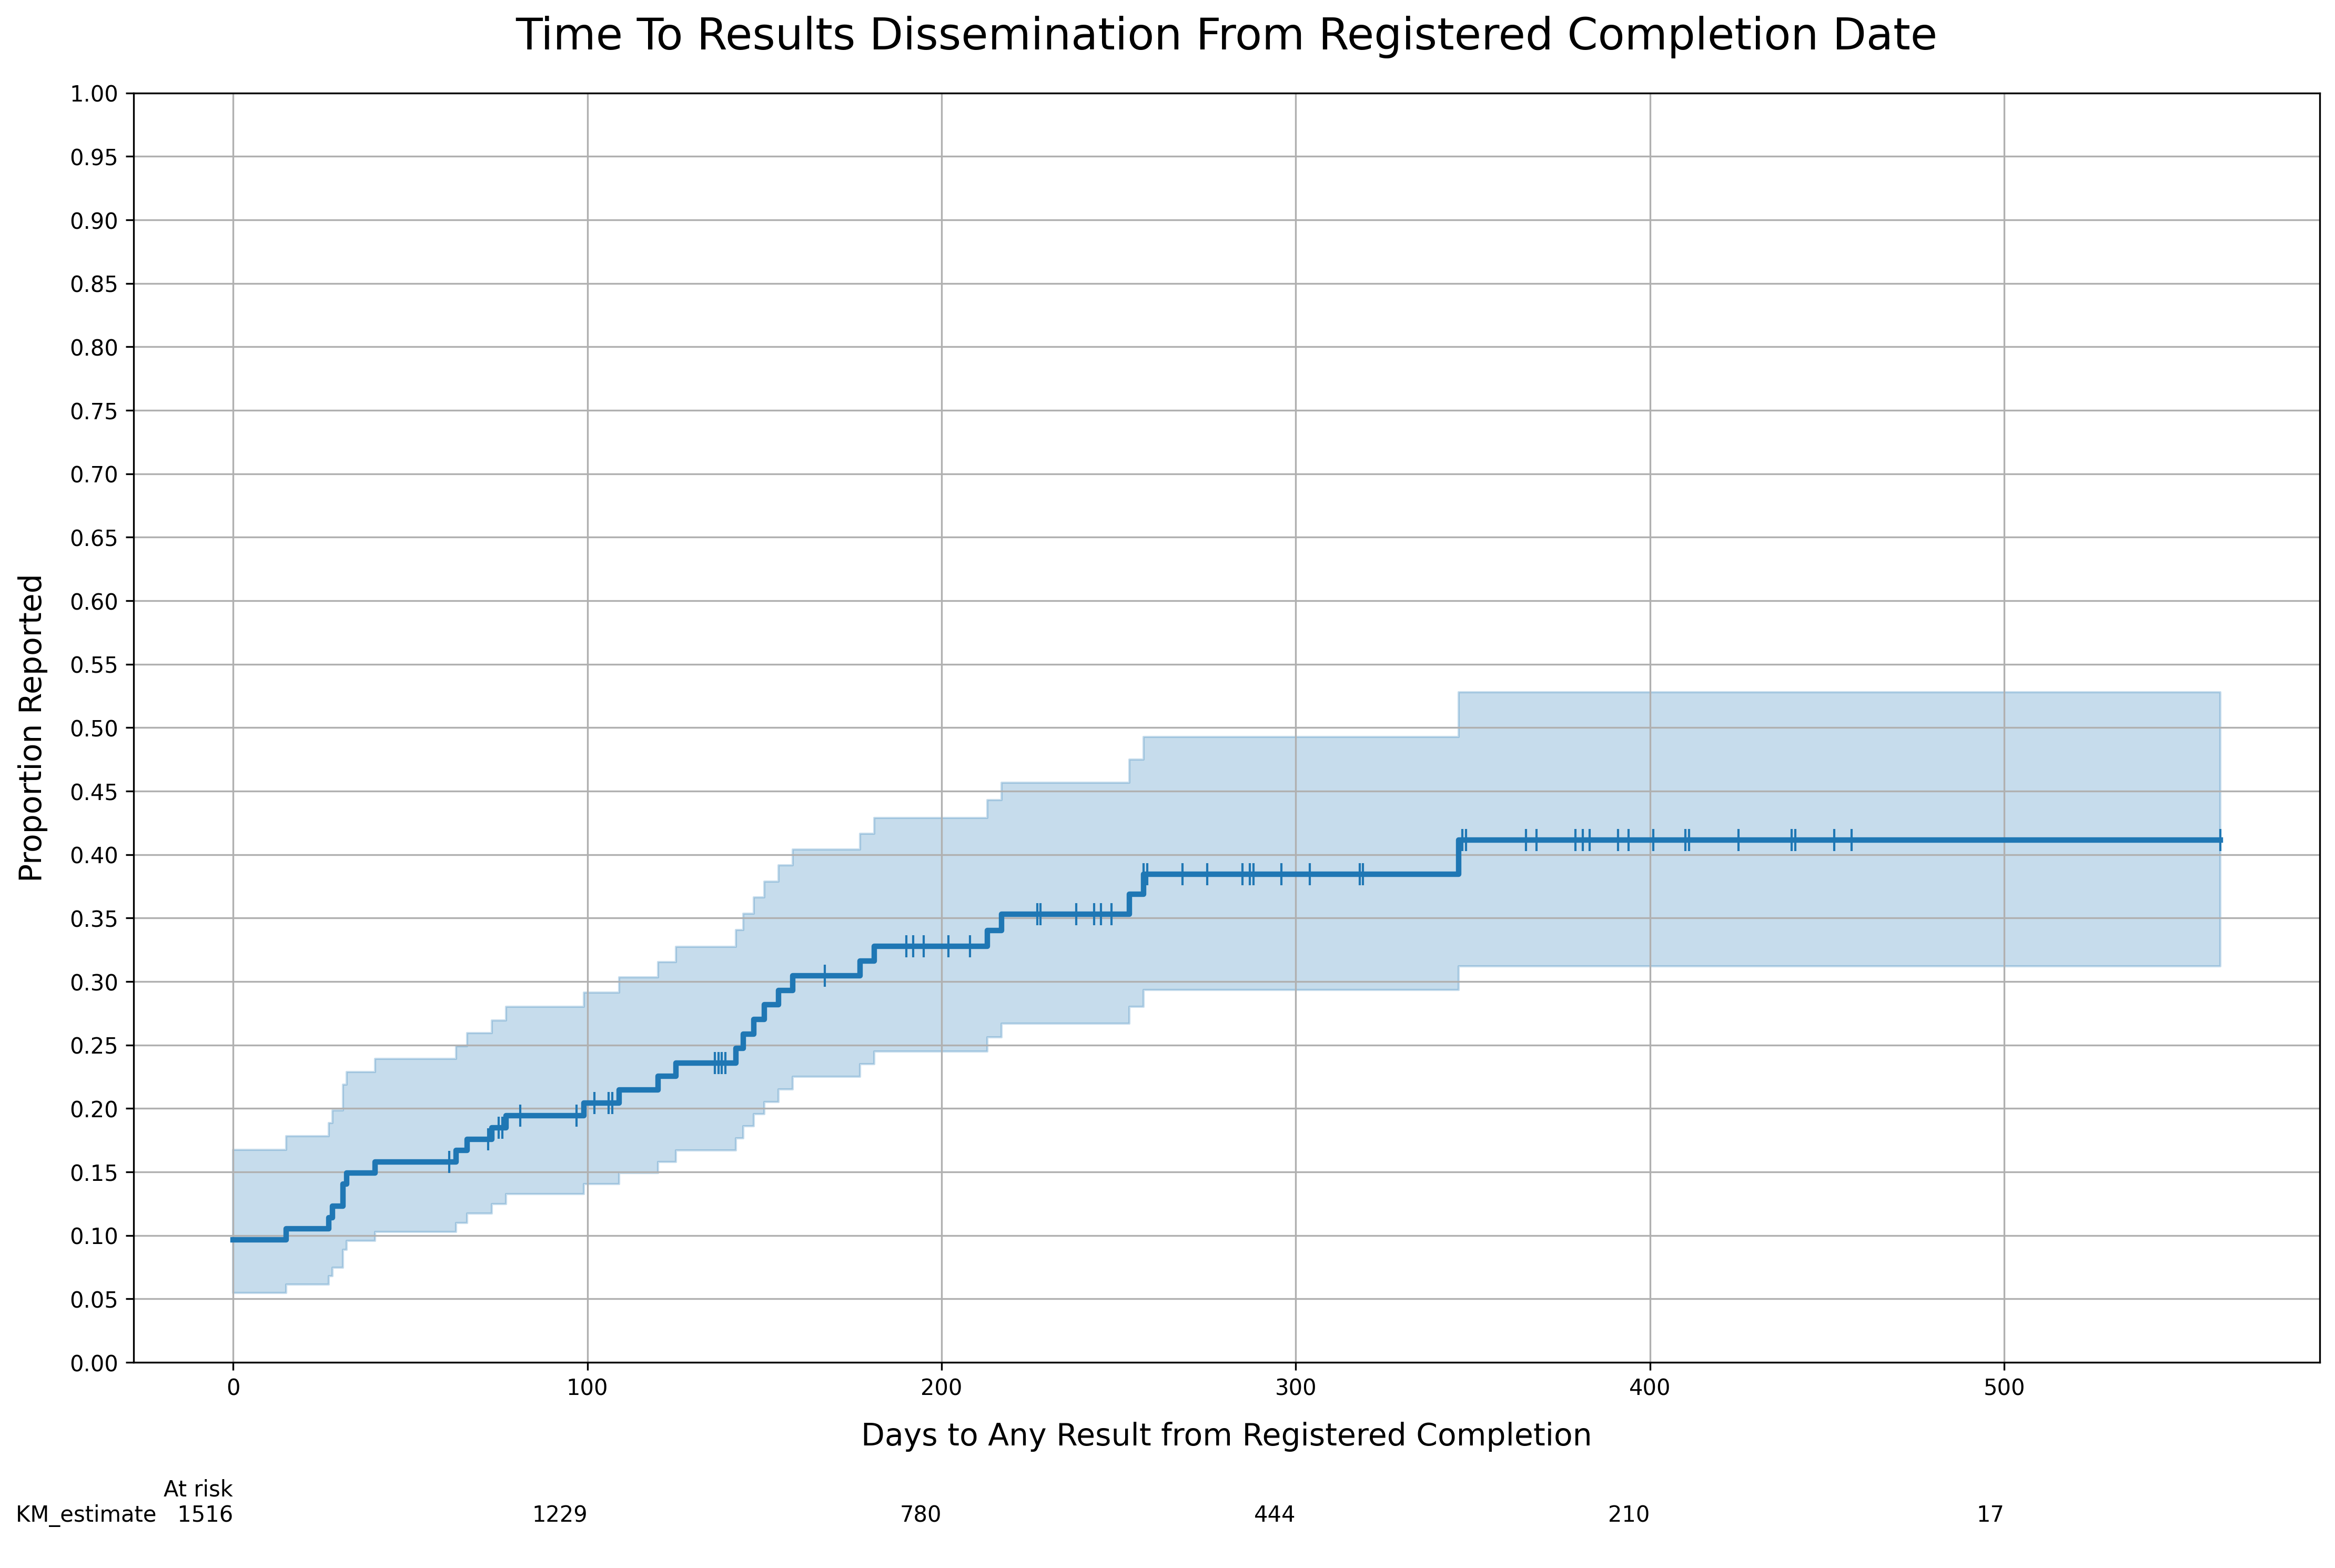

In [66]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T_cp = cp_pub.time_reporting_any_adj
E_cp = cp_pub.publication_any_adj

kmf_cp = KaplanMeierFitter()
kmf_cp.fit(T_cp, E_cp)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_cp.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)

ax.set_ylim([0, 1])

plt.title("Time To Results Dissemination From Registered Completion Date", pad=20, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Result from Registered Completion', labelpad=10, fontsize=14)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_any, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

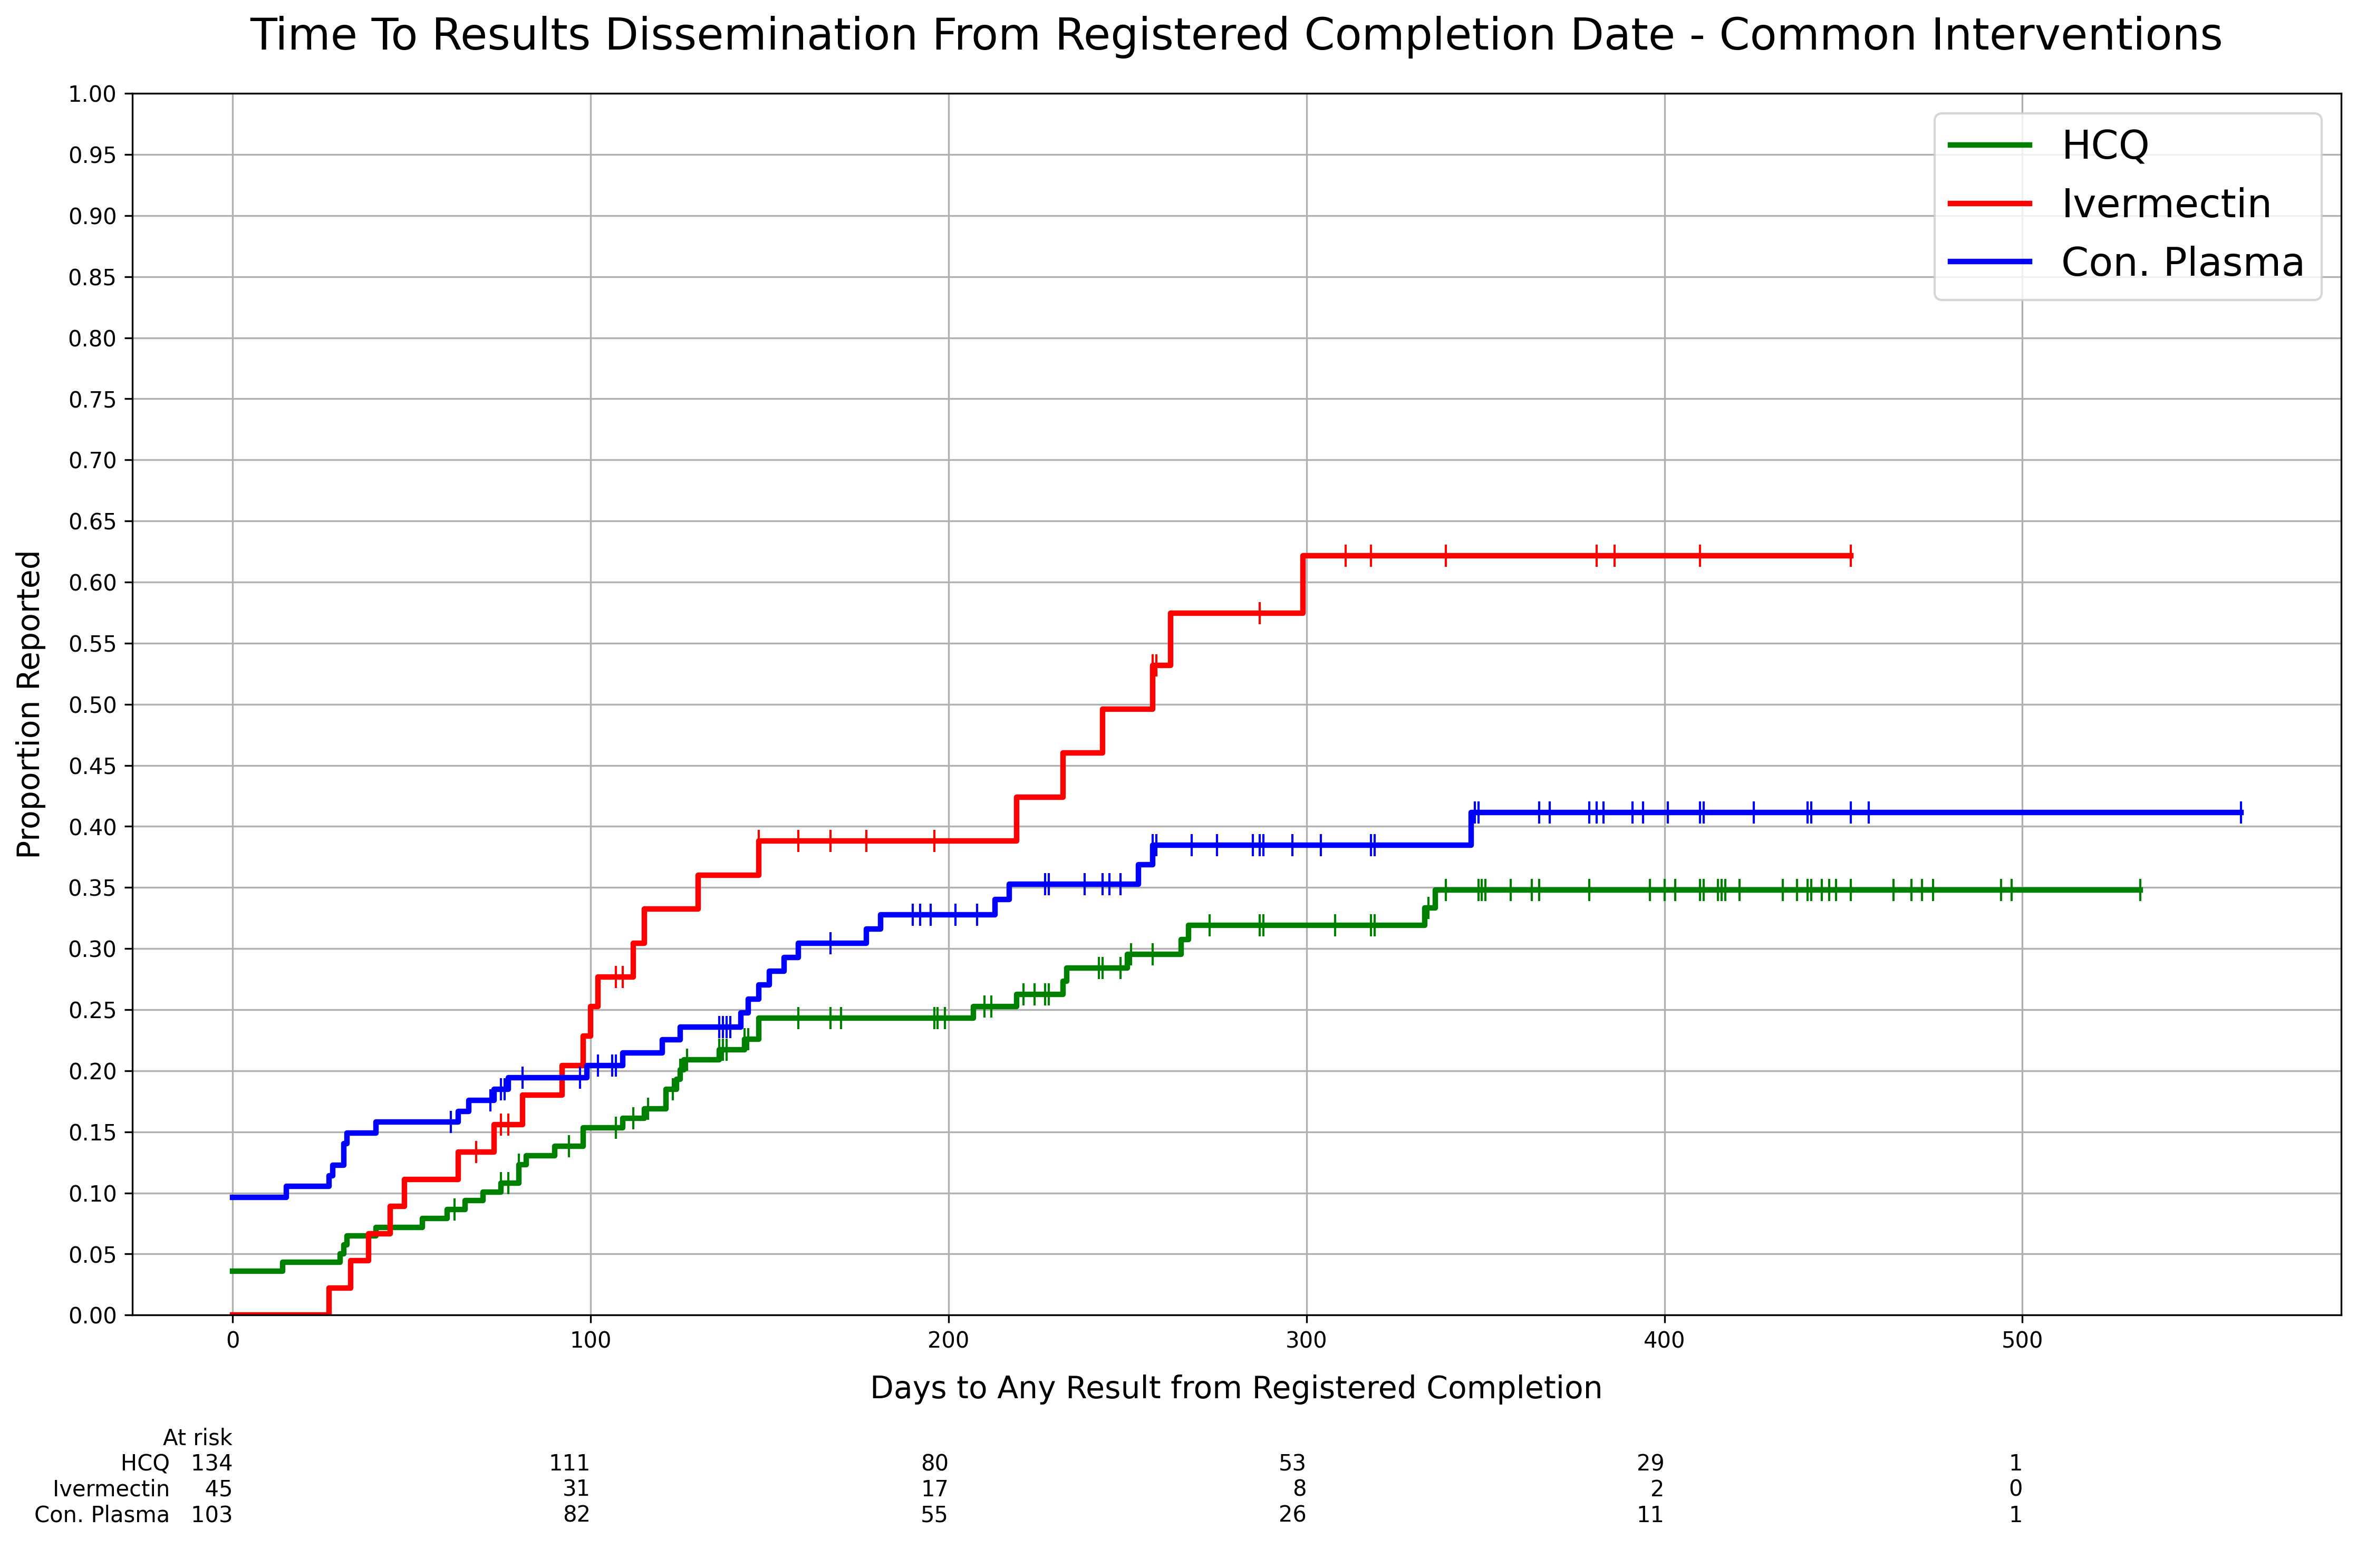

In [67]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

#T1 = phase_pub[phase_pub.pandemic_phase == 1].time_reporting_any_adj
#E1 = phase_pub[phase_pub.pandemic_phase == 1].publication_any_adj

kmf_1 = KaplanMeierFitter()
kmf_1.fit(T_hcq, E_hcq, label='HCQ')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_1.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='green')

#T2 = phase_pub[phase_pub.pandemic_phase == 2].time_reporting_any_adj
#E2 = phase_pub[phase_pub.pandemic_phase == 2].publication_any_adj

kmf_2 = KaplanMeierFitter()
kmf_2.fit(T_ive, E_ive, label='Ivermectin')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_2.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='red')


#T3 = phase_pub[phase_pub.pandemic_phase == 3].time_reporting_any_adj
#E3 = phase_pub[phase_pub.pandemic_phase == 3].publication_any_adj

kmf_3 = KaplanMeierFitter()
kmf_3.fit(T_cp, E_cp, label='Con. Plasma')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_3.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='blue')

ax.set_ylim([0, 1])

plt.title("Time To Results Dissemination From Registered Completion Date - Common Interventions", pad=20, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Result from Registered Completion', labelpad=10, fontsize=14)
ax.legend(fontsize = 18)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_1, kmf_2, kmf_3, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

# Registrations for presentation

In [72]:
test = df2.merge(df_reg[['id','crossreg']], how='left', on='id')

In [73]:
test['reg_result'] = np.where((test.crossreg.str.contains('NCT') | test.crossreg.str.contains('EUCTR') | test.crossreg.str.contains('ISRCTN')), 1,0)

In [74]:
reg_only_km = test[test.reg_result == 1].reset_index(drop=True)

In [75]:
reg_pub2 = reg_only_km[['publication_summary_adj', 'time_publication_summary_adj']].reset_index(drop=True)
reg_pub2['publication_summary_adj'] = reg_pub2['publication_summary_adj'].astype(int)
reg_pub2['time_publication_summary_adj'] = np.where(reg_pub2['time_publication_summary_adj'] < 0, 0, reg_pub2['time_publication_summary_adj'])

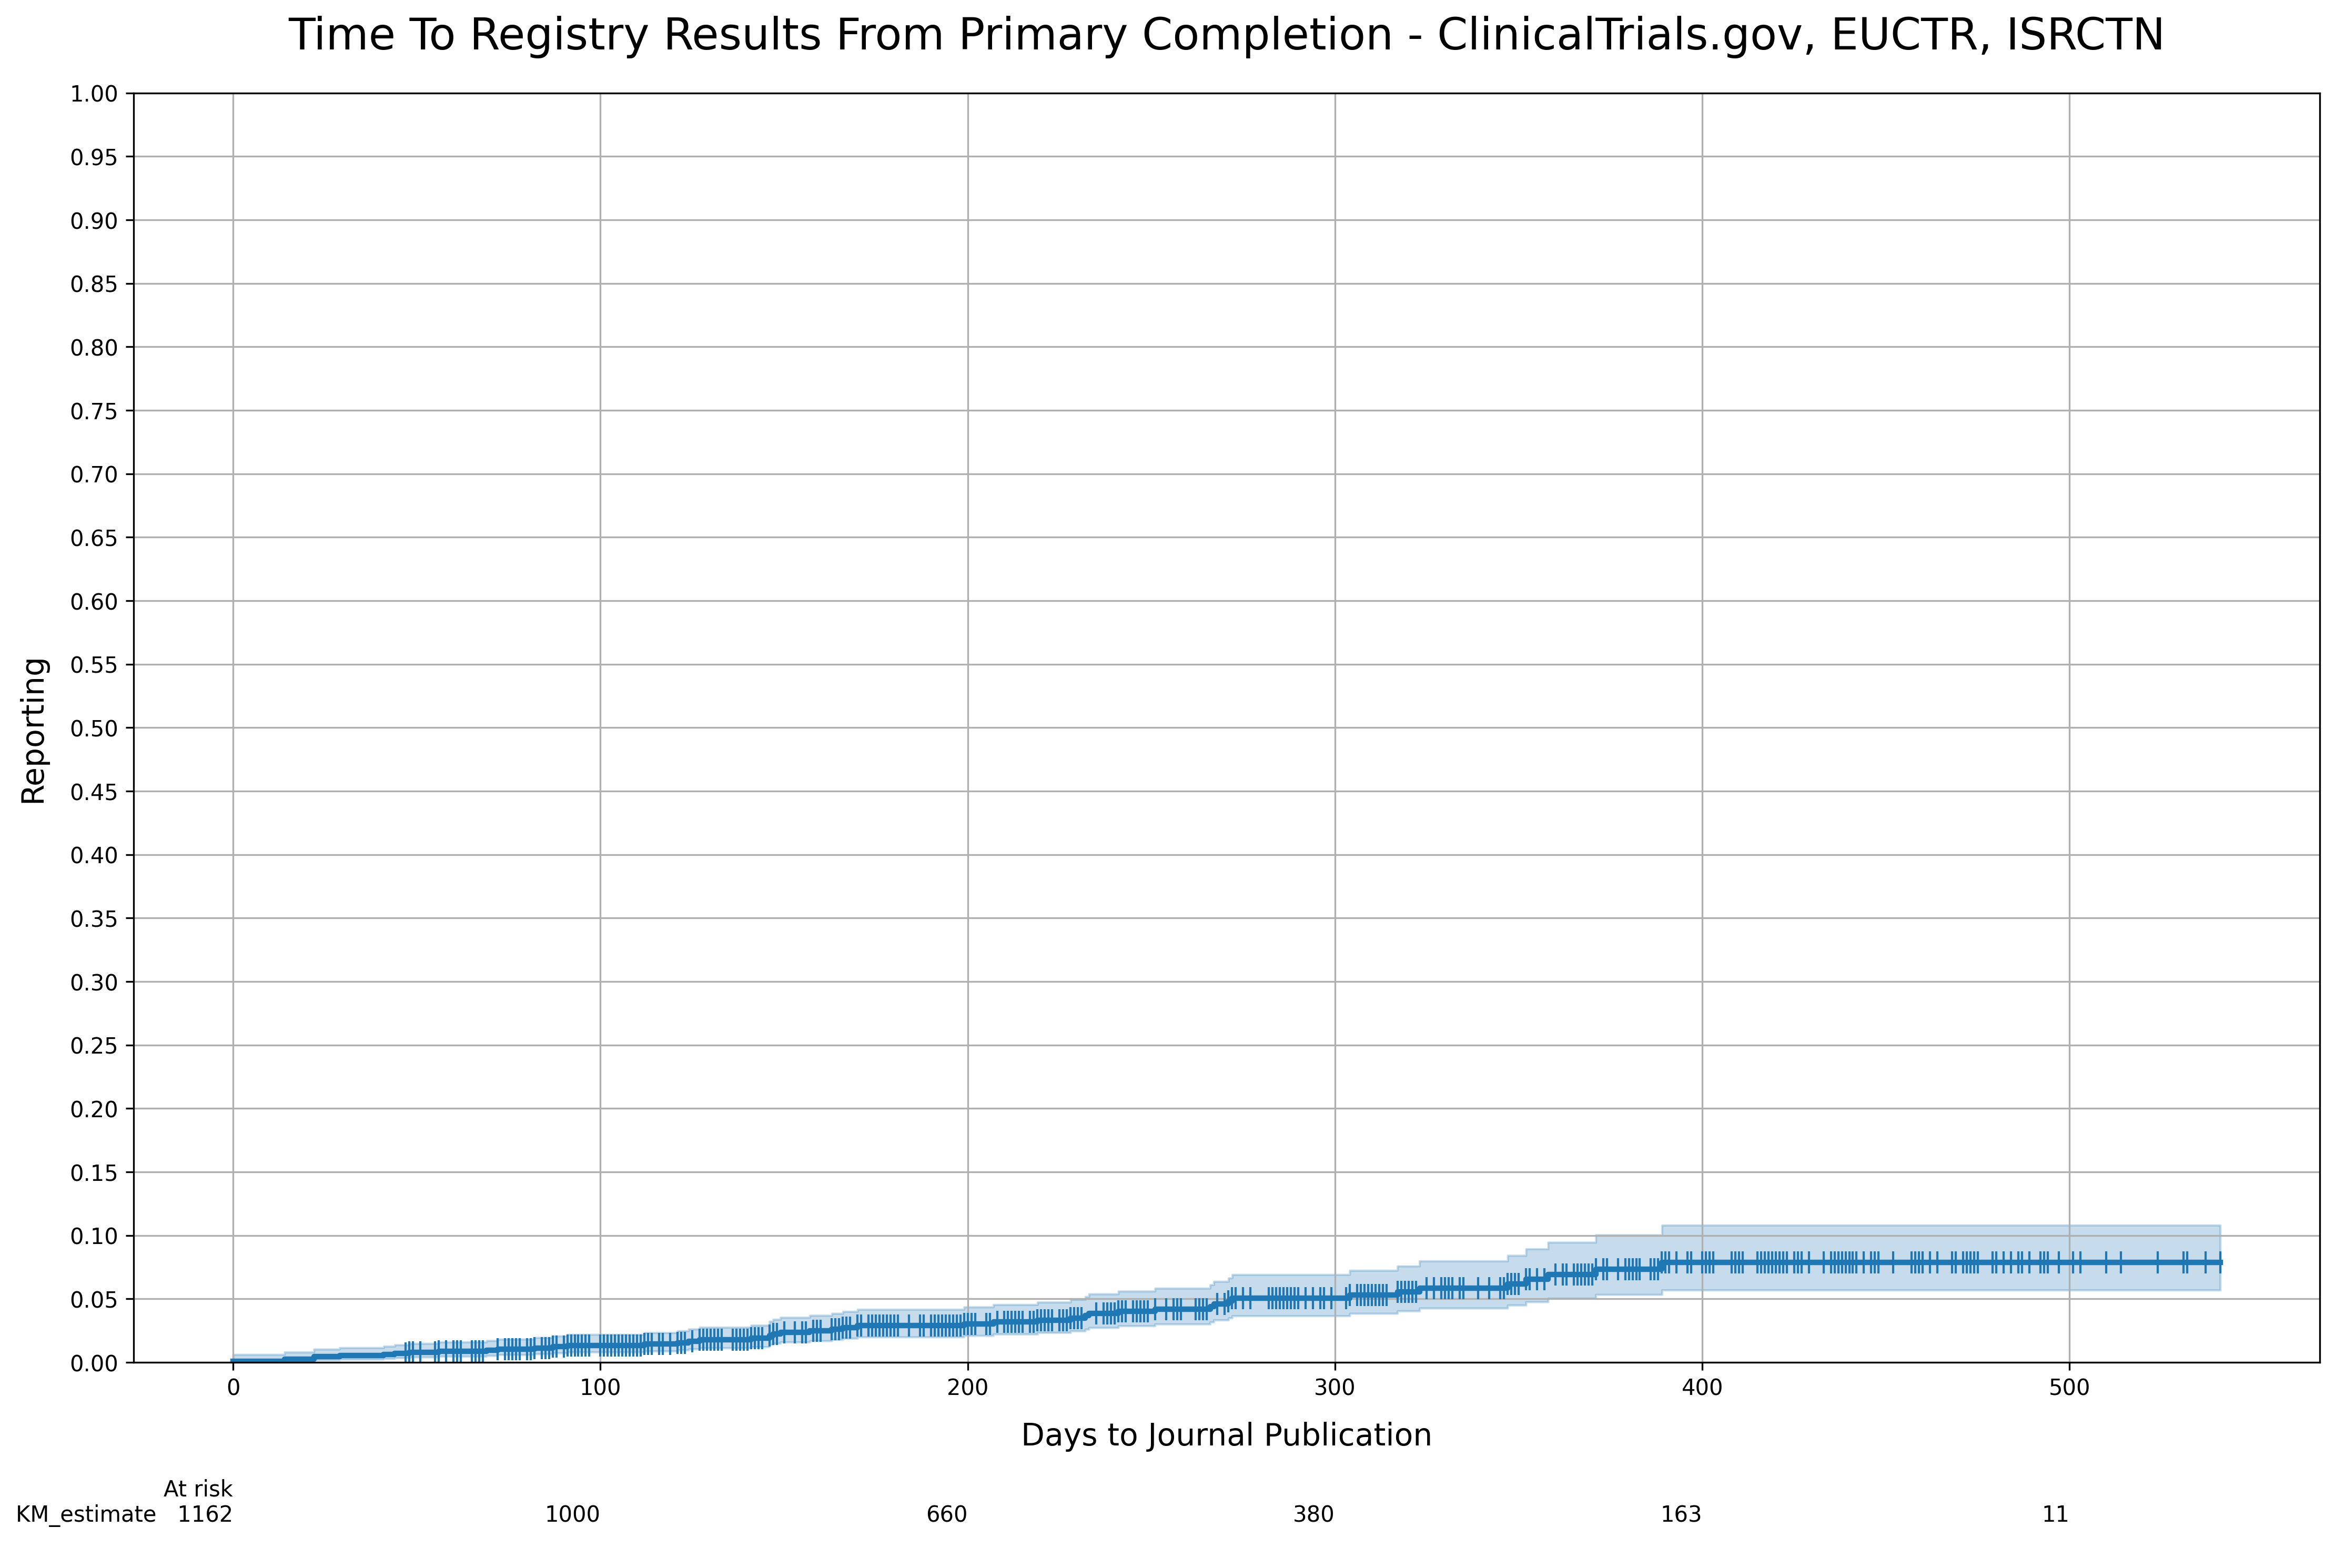

In [76]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T = reg_pub2.time_publication_summary_adj
E = reg_pub2.publication_summary_adj

kmf_article = KaplanMeierFitter()
kmf_article.fit(T, E)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_article.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)

ax.set_ylim([0, 1])

plt.title("Time To Registry Results From Primary Completion - ClinicalTrials.gov, EUCTR, ISRCTN", pad=20, fontsize=20)
plt.ylabel('Reporting', labelpad=10, fontsize=14)
plt.xlabel('Days to Journal Publication', labelpad=10, fontsize=14)

add_at_risk_counts(kmf_article, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

In [ ]:
test.reg_result.sum()

In [ ]:
1163/len(test)

In [ ]:
trials.head()